In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/DNN_Mgard")

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import copy
from sklearn import preprocessing

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

import seaborn as sns
sns.set_style("whitegrid")

current_palette = sns.color_palette("deep")

fontsize=28

from scripts.util import load_var, scatter3D

In [ ]:
# ls datasets/*.csv

In [ ]:
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${}e{}$'.format(a, b)

In [ ]:
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"{func}:{elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [ ]:
# Those old ones before 08/03/2023
Time_paths_old = [
    "datasets/Warpx_00300_bx/run_mgard_1e-1_full.csv",
    "datasets/Warpx_00300_bx/run_mgard_1e-3_full.csv",
    "datasets/Warpx_00300_bx/run_mgard_1e-5_full.csv",
    "datasets/Warpx_00300_bx/run_mgard_1e-7_full.csv",
    "datasets/Warpx_00300_ex/run_mgard_1e-1_full.csv",
    "datasets/Nyx_baryon_density/run_mgard_1e-1_full.csv",
    "datasets/Nyx_dark_matter_density/run_mgard_1e-1_full.csv",
    "datasets/Nyx_temperature/run_mgard_1e-1_full.csv",
    "datasets/Nyx_velocity_x/run_mgard_1e-1_full.csv",
    "datasets/Hurrican_cloud48_log/run_mgard_1e-1_full.csv",
    "datasets/Hurrican_qcloud48_log/run_mgard_1e-1_full.csv",
    ]

# New applications across error bounds - 08/03/2023.
Time_paths_new = [
    # hurricane
    # "datasets/cloudf48_log_1.00e-06.csv",
    "datasets/cloudf48_log_1.01e-04.csv",
    "datasets/cloudf48_log_1.02e-02.csv",
    "datasets/cloudf48_log_1.02e+00.csv",
    # "datasets/precipf48_log_3.50e-06.csv",
    "datasets/precipf48_log_3.58e-04.csv",
    "datasets/precipf48_log_3.58e-02.csv",
    "datasets/precipf48_log_3.58e+00.csv",
    # "datasets/qgraupf48_log_3.50e-06.csv",
    "datasets/qgraupf48_log_3.57e-04.csv",
    "datasets/qgraupf48_log_3.58e-02.csv",
    "datasets/qgraupf48_log_3.58e+00.csv",
    # "datasets/qicef48_log_1.80e-06.csv",
    "datasets/qicef48_log_1.86e-04.csv",
    "datasets/qicef48_log_1.87e-02.csv",
    "datasets/qicef48_log_1.87e+00.csv",

    ##  nyx
    # "datasets/baryon_density_1.16e-02.csv",
    "datasets/baryon_density_1.16e+00.csv",
    "datasets/baryon_density_1.16e+02.csv",
    "datasets/baryon_density_1.16e+04.csv",
    # "datasets/dark_matter_density_1.38e-03.csv",
    "datasets/dark_matter_density_1.38e-01.csv",
    "datasets/dark_matter_density_1.38e+01.csv",
    "datasets/dark_matter_density_1.38e+03.csv",
    # "datasets/temperature_4.78e-01.csv",
    "datasets/temperature_4.78e+01.csv",
    "datasets/temperature_4.78e+03.csv",
    "datasets/temperature_4.78e+05.csv",
    # "datasets/velocity_x_8.23e+00.csv",
    "datasets/velocity_x_8.23e+02.csv",
    "datasets/velocity_x_8.23e+04.csv",
    "datasets/velocity_x_8.23e+06.csv",

    ### scale
    # "datasets/pres-98x1200x1200_9.95e-03.csv",
    "datasets/pres-98x1200x1200_9.95e-01.csv",
    "datasets/pres-98x1200x1200_9.95e+01.csv",
    "datasets/pres-98x1200x1200_9.95e+03.csv",
    # "datasets/qc-98x1200x1200_3.01e-10.csv",
    "datasets/qc-98x1200x1200_3.01e-08.csv",
    "datasets/qc-98x1200x1200_3.01e-06.csv",
    "datasets/qc-98x1200x1200_3.01e-04.csv",
    # "datasets/qg-98x1200x1200_1.49e-09.csv",
    "datasets/qg-98x1200x1200_1.49e-07.csv",
    "datasets/qg-98x1200x1200_1.49e-05.csv",
    "datasets/qg-98x1200x1200_1.49e-03.csv",
    # "datasets/qi-98x1200x1200_1.60e-10.csv",
    "datasets/qi-98x1200x1200_1.60e-08.csv",
    "datasets/qi-98x1200x1200_1.60e-06.csv",
    "datasets/qi-98x1200x1200_1.60e-04.csv",
    ]

Threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10,
             0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20,
             0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30,
             0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]

Time_paths_lvl2 = ["datasets/baryon_density_1.16e+04_lvl2.csv",
                   "datasets/cloudf48_log_1.02e+00_lvl2.csv",
                   "datasets/pres-98x1200x1200_9.95e+03_lvl2.csv"]

Time_paths_lvl3 = ["datasets/baryon_density_1.16e+04_lvl3.csv",
                   "datasets/cloudf48_log_1.02e+00_lvl3.csv",
                   "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]

Time_paths_lvl4 = ["datasets/baryon_density_1.16e+04_lvl4.csv",
                   "datasets/cloudf48_log_1.02e+00_lvl4.csv",
                   "datasets/pres-98x1200x1200_9.95e+03_lvl4.csv"]

## Data analytics

In [ ]:
def scatter3D(data, axs, var, alpha, elev=30, azim=45, roll=0):
    xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data)
    vdata = data[var].values

    if var == "estimated_error":
        cmap = "magma"
    elif var == "MaxErr":
        cmap = "plasma"
    elif var == "Total_retrieve_size":
        cmap = "viridis"

    axs.view_init(elev=elev, azim=azim, roll=roll)
    img = axs.scatter(xdata, ydata, zdata, c=vdata, cmap=cmap, vmin=np.min(vdata), vmax=np.max(vdata), s=1.5, alpha=alpha) # norm=colors.LogNorm(),#

    if azim in [0, 45]:
        # try not to change this
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey',  alpha=.5)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='grey',  alpha=.5)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey',  alpha=.5)

        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)

    if azim == 225:
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey', alpha=.5)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey', alpha=.5)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='grey', alpha=.5)

        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)


    axs.set_xlim(0, 6)
    axs.set_ylim(0, 6)
    axs.set_zlim(0, 6)

    axs.set_xlabel('C0', labelpad=18, fontsize=fontsize)
    axs.set_ylabel('C1', labelpad=18, fontsize=fontsize)
    axs.set_zlabel('C2', labelpad=6, fontsize=fontsize)
    axs.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    axs.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    axs.set_zticks([0, 1, 2, 3, 4, 5, 6]);
    axs.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    axs.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    axs.set_zticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    return img

In [ ]:

def plot_scatter3D(time_path):
    data0 = pd.read_csv(time_path).drop_duplicates()
    dname = time_path.split("/")[1]
    reqerr = data0["Requested_tolerance"].values[0]
    c0 = data0[(data0.MaxErr > reqerr)].c0.values
    c1 = data0[(data0.MaxErr > reqerr)].c1.values
    c2 = data0[(data0.MaxErr > reqerr)].c2.values

    plt.rcParams["figure.figsize"] = [15, 15]
    fig = plt.figure()

    # ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    # ax1.set_title("rotation=0", fontsize=fontsize)
    # img = scatter3D(data0, ax1, "estimated_error", .8, 30, 0, 0)
    # cbar = fig.colorbar(img, orientation="horizontal", fraction=0.08, pad=0.05)
    # cbar.ax.tick_params(labelsize=fontsize)
    # # img = ax1.scatter(c0, c1, c2, color="red", marker="^", alpha=1, s=4)

    ax2 = fig.add_subplot(1, 1, 1, projection='3d')
    # ax2.set_title("rotation=45", fontsize=fontsize)
    img = scatter3D(data0, ax2, "estimated_error", .8, 30, 45, 0)
    # img = scatter3D(data0, ax2, "Total_retrieve_size", .8, 30, 45, 0)
    cbar = fig.colorbar(img, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.09, pad=0.02)
    cbar.ax.tick_params(labelsize=fontsize)

    # # I/O
    # if dname == "baryon_density_1.16e+04_lvl3.csv":
    #     cbar.set_ticks([1e4, 2e4, 3e4])
    # elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
    #     cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    # elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
    #     cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    # # img = ax2.scatter(c0, c1, c2, color="red", marker="^", alpha=1, s=4)

    # # Maxerr
    # if dname == "baryon_density_1.16e+04_lvl3.csv":
    #     cbar.set_ticks([1e3, 1e4, 4e4, 8e4])
    # elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
    #     cbar.set_ticks([1e-1, 1e1, 2e1])
    # elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
    #     cbar.set_ticks([1e3, 1e4, 2e4, 4e4])
    # # img = ax2.scatter(c0, c1, c2, color="red", marker="^", alpha=1, s=4)

    # ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    # ax3.set_title("rotation=225", fontsize=fontsize)
    # img = scatter3D(data0, ax3, "estimated_error", .8, 30, 225, 0)
    # cbar = fig.colorbar(img, orientation="horizontal", fraction=0.08, pad=0.05)
    # cbar.ax.tick_params(labelsize=fontsize)
    # # img = ax3.scatter(c0, c1, c2, color="red", marker="^", alpha=1, s=4)

    # ax1.set_xlim(0, 6)
    # ax1.set_ylim(0, 6)
    # ax1.set_zlim(0, 6)
    ax2.set_xlim(0, 6)
    ax2.set_ylim(0, 6)
    ax2.set_zlim(0, 6)
    # ax3.set_xlim(0, 6)
    # ax3.set_ylim(0, 6)
    # ax3.set_zlim(0, 6)
    # plt.show()

    # fig.tight_layout()
    plt.savefig("{}_scatter3D_estierr.png".format(dname.replace("_lvl4", "").replace(".csv", "")), dpi="figure", format="png")

In [ ]:
def plot_slice_lvl2(time_path):
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    plt.rcParams["figure.figsize"] = [5*1.2, 5]
    fig1 = plt.figure()

    # I/O size
    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values
    ax1 = fig1.add_subplot(1, 1, 1)
    img1 = ax1.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=15)

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    fig1.tight_layout()
    fig1.show()

In [ ]:
def plot_slice_lvl3(time_path):
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    plt.rcParams["figure.figsize"] = [15*1.2, 5]
    fig1 = plt.figure()

    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    # I/O size
    ax1 = fig1.add_subplot(131)
    img1 = ax1.scatter(c1, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    # cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.3)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(132)
    img1 = ax1.scatter(c0, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    # cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.3)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(133)
    img1 = ax1.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    # cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.3)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    fig1.tight_layout()
    fig1.show()

    plt.savefig("{}_io_slice_lvl3.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", format="pdf")

In [ ]:
def plot_slice_lvl4(time_path):
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    plt.rcParams["figure.figsize"] = [30*1.2, 5]
    fig1 = plt.figure()

    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    c3 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c3.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    # I/O size
    ax1 = fig1.add_subplot(161)
    img1 = ax1.scatter(c2, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl4.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl4.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl4.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C2', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C3', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(162)
    img1 = ax1.scatter(c1, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl4.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl4.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl4.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C3', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(163)
    img1 = ax1.scatter(c0, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl4.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl4.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl4.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C3', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(164)
    img1 = ax1.scatter(c1, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(165)
    img1 = ax1.scatter(c0, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(166)
    img1 = ax1.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    fig1.tight_layout()
    fig1.show()
    plt.savefig("{}_io_slice_lvl4.pdf".format(dname.replace("_lvl4", "").replace(".csv", "")), dpi="figure", format="pdf")

In [ ]:
def plot_scatter3D_e(time_path):
    dname = time_path.split("/", 3)[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0)
    reqerr = redata[0]

    plt.rcParams["figure.figsize"] = [15*1.2, 5]
    fig = plt.figure()

    # =========================== I/O size - c1/c2
    ax1 = fig.add_subplot(1, 3, 1)
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    img1 = ax1.scatter(c1, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])


    # # when medata > reqerr
    c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
    c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
    ax1.scatter(c1, c2, color="red", marker="s", alpha=1, s=4)

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax1.set_title("{} - I/O size".format(dname), fontsize=fontsize)

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    # =========================== I/O size - c0/c2
    ax2 = fig.add_subplot(1, 3, 2)
    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    img1 = ax2.scatter(c0, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # when medata > reqerr
    c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
    c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
    ax2.scatter(c0, c2, color="red", marker="s", alpha=1, s=4)

    ax2.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax2.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax2.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax2.set_title("{} - I/O size".format(dname), fontsize=fontsize)

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")

    # =========================== I/O size - c0/c1
    ax2 = fig.add_subplot(1, 3, 3)
    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    img1 = ax2.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # when medata > reqerr
    c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
    c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
    ax2.scatter(c0, c1, color="red", marker="s", alpha=1, s=4)

    ax2.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax2.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    ax2.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax2.set_title("{} - I/O size".format(dname), fontsize=fontsize)

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")

    fig.tight_layout()
    fig.show()
    plt.savefig("{}_io_ne.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", format="pdf")

In [ ]:
def plot_slice(time_path, x, y):
    """
    x and y can be any of c0, ... c3
    """
    # Thresholds = [0.01, 0.02, 0.03, 0.04, 0.05,]
    Thresholds = [0.05, 0.10, 0.15, 0.20, 0.25,]

    plt.rcParams["figure.figsize"] = [5*len(Thresholds)*1.2, 5]
    fig1 = plt.figure()
    for i in np.arange(0, len(Thresholds)):
        threshold = Thresholds[i]
        dname = time_path.split("/")[1]
        data0 = pd.read_csv(time_path).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        # I/O size
        ax1 = fig1.add_subplot(1,5,i+1)

        xx = data0[(data0.estimated_error >= reqerr*(1-threshold))][x].values
        yy = data0[(data0.estimated_error >= reqerr*(1-threshold))][y].values
        trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

        img1 = ax1.scatter(xx, yy, c=trsdata, cmap="viridis", alpha=1, s=4)
        cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
        cbar.ax.tick_params(labelsize=fontsize)

        # if "baryon_density" in dname:
        #     cbar.set_ticks([1e4, 2e4, 3e4])
        # elif "cloudf48" in dname:
        #     cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
        # elif "pres" in dname:
        #     cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

        # when medata > reqerr
        xx = data0[ (data0.estimated_error >= reqerr*(1-threshold)) & (data0.MaxErr > reqerr)][x].values
        yy = data0[ (data0.estimated_error >= reqerr*(1-threshold)) & (data0.MaxErr > reqerr)][y].values

        img1 = ax1.scatter(xx, yy, color="red", marker="s", alpha=1, s=4)
        ax1.set_xlabel(x.upper(), labelpad=10, fontsize=fontsize)
        ax1.set_ylabel(y.upper(), labelpad=5, fontsize=fontsize)
        ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.text(6, 5.4, "Threshold={:.2}".format(threshold), fontsize=fontsize, ha="right")

        ax1.spines["bottom"].set_color("black")
        ax1.spines["top"].set_color("black")
        ax1.spines["right"].set_color("black")
        ax1.spines["left"].set_color("black")

    fig1.tight_layout()
    fig1.show()
    plt.savefig("{}_io_eb_th.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), bbox_inches='tight', format="pdf")

### Pattern manifestation - 2 levels

In [ ]:
# threshold = 0.03
# for time_path in ["datasets/baryon_density_1.16e+04_lvl2.csv", "datasets/cloudf48_log_1.02e+00_lvl2.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl2.csv"]:
#     plot_slice_lvl2(time_path)

### Pattern manifestation - 3 levels

In [ ]:
threshold = 0.03
for time_path in ["datasets/baryon_density_1.16e+04_lvl3.csv", "datasets/cloudf48_log_1.02e+00_lvl3.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]:
    plot_slice_lvl3(time_path)

Output hidden; open in https://colab.research.google.com to view.

### Pattern manifestation - 4 levels

In [ ]:
threshold = 0.03
for time_path in ["datasets/baryon_density_1.16e+04_lvl4.csv", "datasets/cloudf48_log_1.02e+00_lvl4.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl4.csv"]:
    plot_slice_lvl4(time_path)

Output hidden; open in https://colab.research.google.com to view.

### Misc patterns

In [ ]:
for time_path in ["datasets/baryon_density_1.16e+04_lvl3.csv", "datasets/cloudf48_log_1.02e+00_lvl3.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]:
    plot_scatter3D(time_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
threshold = 0.03
for time_path in ["datasets/baryon_density_1.16e+04_lvl3.csv", "datasets/cloudf48_log_1.02e+00_lvl3.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]: #
    plot_scatter3D_e(time_path)

Output hidden; open in https://colab.research.google.com to view.

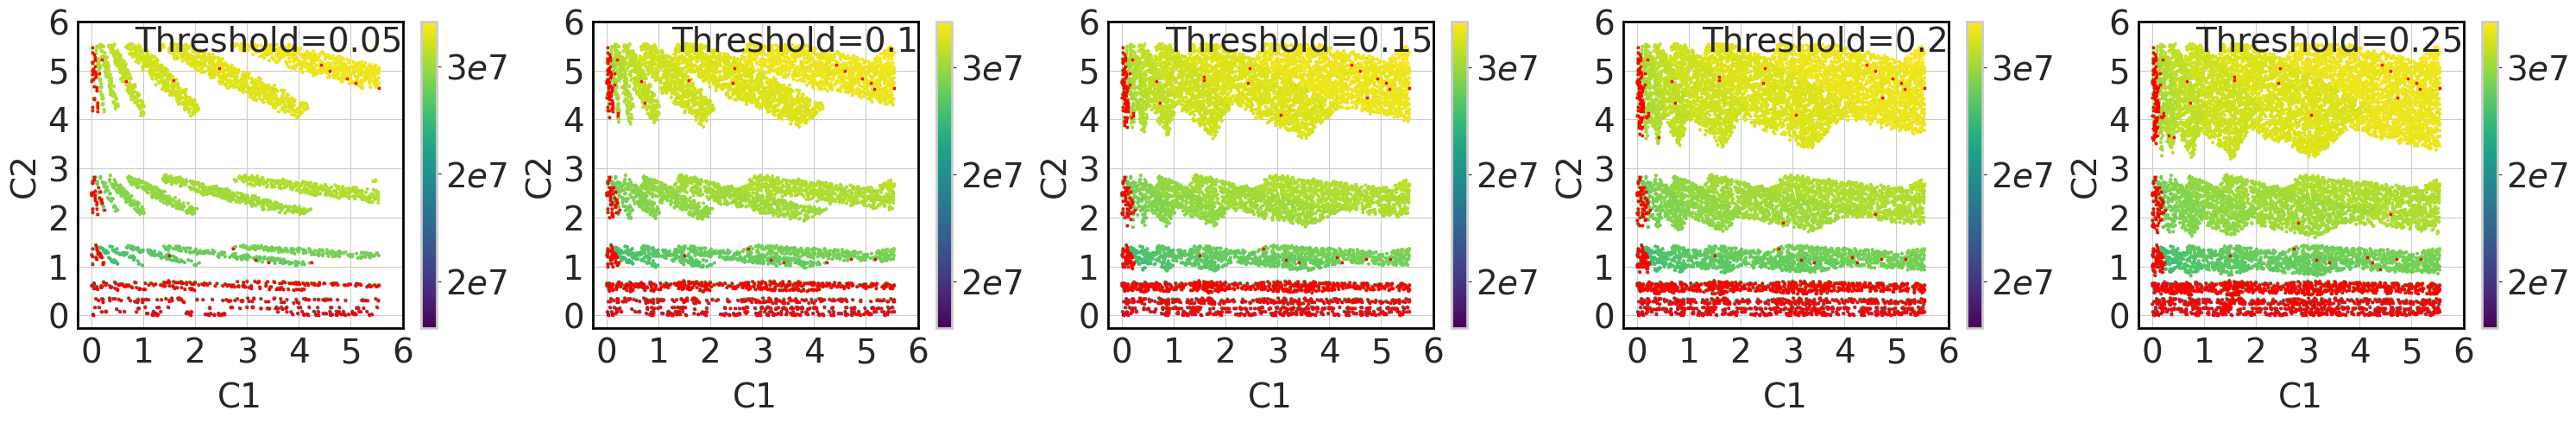

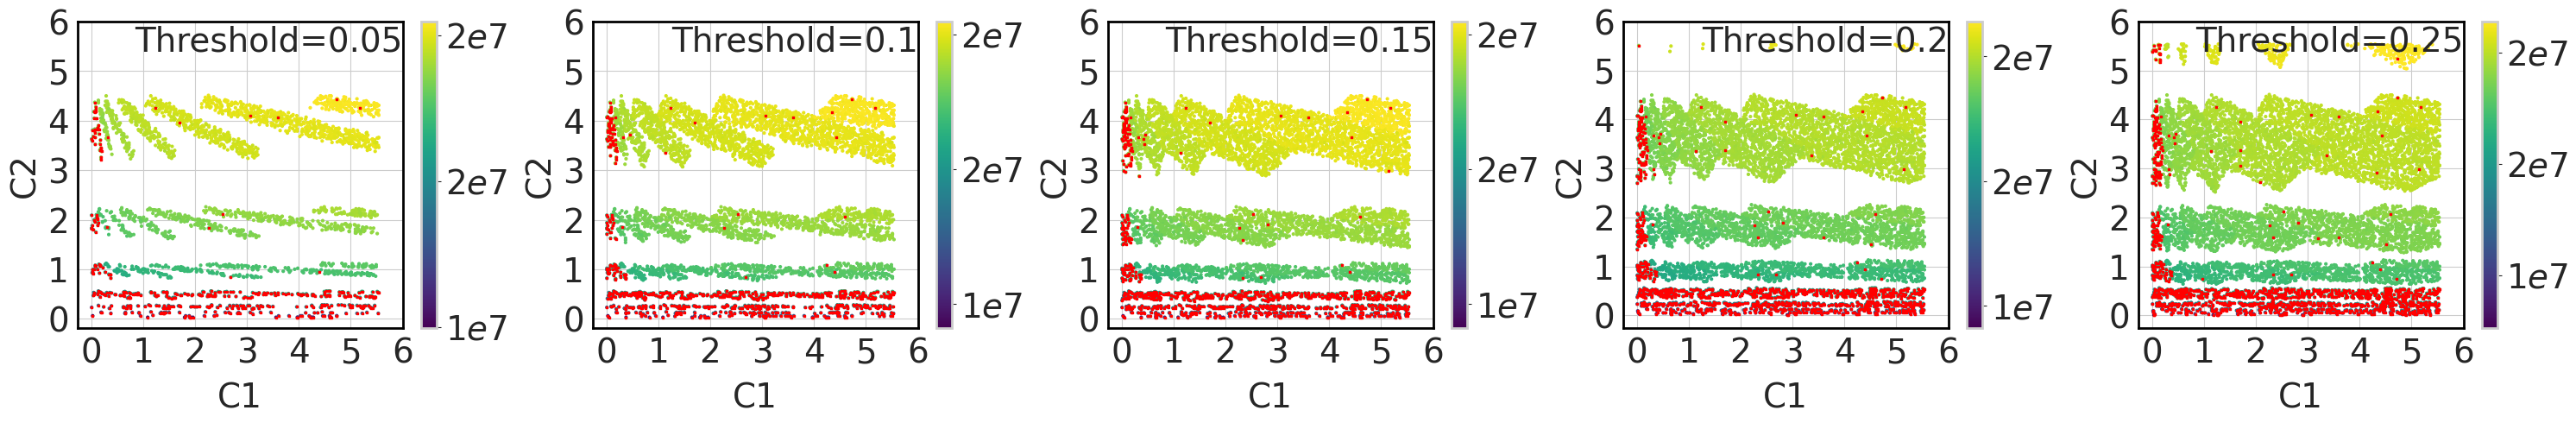

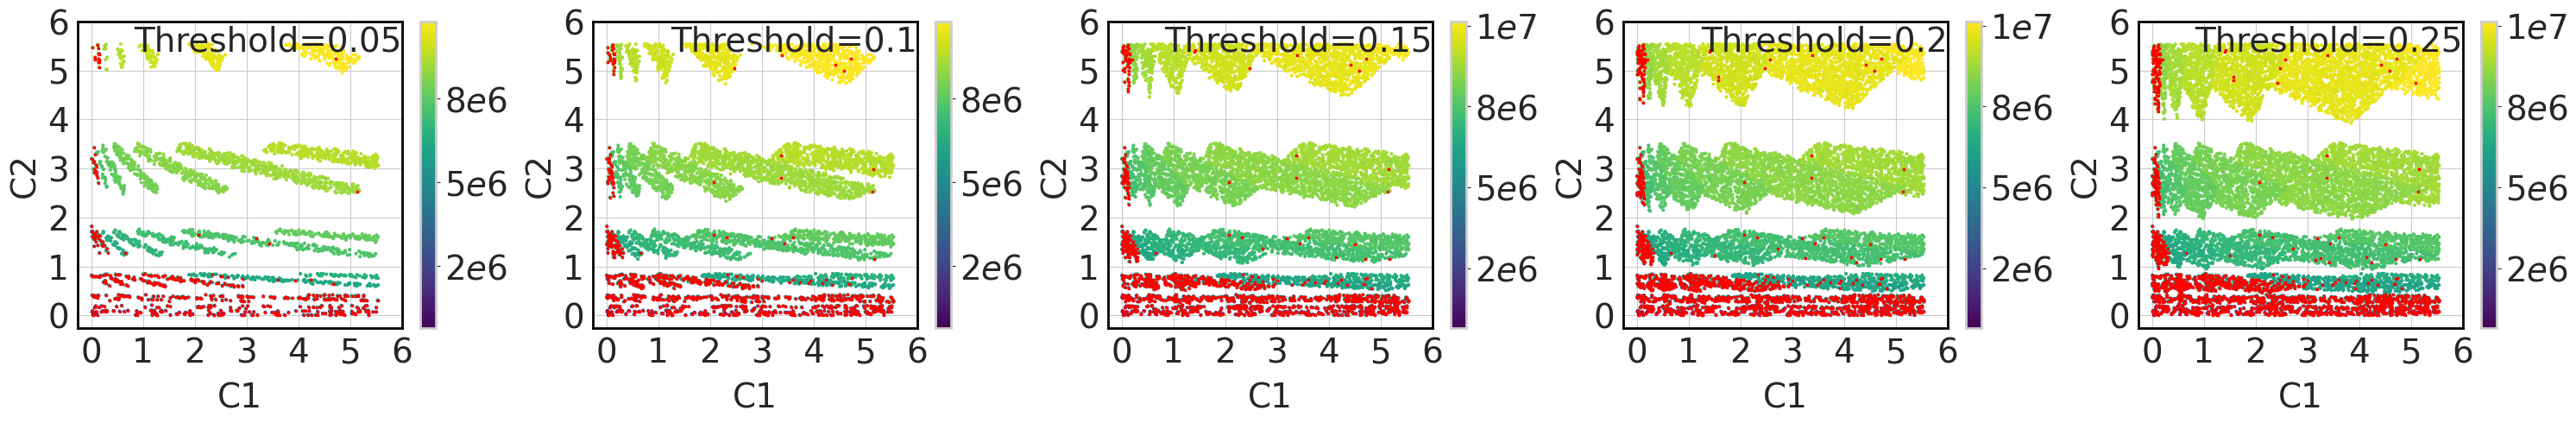

In [ ]:
for time_path in ["datasets/cloudf48_log_1.01e-04.csv",
                  "datasets/cloudf48_log_1.02e-02.csv",
                  "datasets/cloudf48_log_1.02e+00.csv",
                  ]:

# for time_path in ["datasets/baryon_density_1.16e+00.csv",
#                   "datasets/baryon_density_1.16e+02.csv",
#                   "datasets/baryon_density_1.16e+04.csv",
#                   ]:

# for time_path in ["datasets/pres-98x1200x1200_9.95e-01.csv",
#                   "datasets/pres-98x1200x1200_9.95e+01.csv",
#                   "datasets/pres-98x1200x1200_9.95e+03.csv",]:

    plot_slice(time_path, "c1", "c2")

## Modeling

In [ ]:

def alpha_shape_2d(points, alpha, only_outer=True):
    """
    # https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [ ]:

def search_alpha_shape_2d(points_miss, points_hit, use_contour=False):
    # search interval
    s_bin = 0.3

    # construct a 2d alpha_shape and find the contour
    if use_contour:
        edges = alpha_shape_2d(np.array(points_miss[:, [-2,-1]]), alpha=(np.log10(1/threshold)+.1), only_outer=False)
        Contour = []
        for i, j in edges:
            if [points_miss[i][0], points_miss[i][1]] not in Contour:
                Contour.append([points_miss[i][0], points_miss[i][1]])

            if [points_miss[j][0], points_miss[j][1]] not in Contour:
                Contour.append([points_miss[j][0], points_miss[j][1]])

        points_miss = np.array(Contour) # or points_miss
    else:
        points_miss = np.array(points_miss) # or points_miss

    vx = []
    vy = []
    for cx in np.arange(0.00, 6, s_bin):
        cx = np.around(cx, 2)

        chunk = points_miss[(points_miss[:, 0] >= cx - s_bin) & (points_miss[:, 0] < cx)]
        if len(chunk):
            vx.append(chunk[chunk[:, 1] == np.max(chunk[:, 1])][0][0])
            vy.append(chunk[chunk[:, 1] == np.max(chunk[:, 1])][0][1])

    # find the lower left corner of curve-missed points
    vmin = 99
    Vx = 0
    Vy = 0
    for vx_, vy_ in zip(vx, vy):
            if vx_+vy_ < vmin:
                vmin = vx_+vy_
                Vx = vx_
                Vy = vy_

    # find the nearst curve-hit point
    dmin = 2
    dx = 0
    dy = 0
    for px, py in points_hit:
        if np.sqrt((px-Vx)**2 + (py-Vy)**2) < dmin:
            dmin = np.sqrt((px-Vx)**2 + (py-Vy)**2)
            dx = px
            dy = py

    return vx, vy, Vx, Vy, dx, dy

In [ ]:

def search_alpha_shape_3d(points_miss, points_hit, use_contour=False):
    # search interval
    s_bin = 0.1

    # construct a 2d alpha_shape and find the contour
    if use_contour:
        edges = alpha_shape_2d(np.array(points_miss[:, [-2,-1]]), alpha=(np.log10(1/threshold)+.1)/10, only_outer=False)
        Contour = []
        for i, j in edges:
            if [points_miss[i][0], points_miss[i][1], points_miss[i][2]] not in Contour:
                Contour.append([points_miss[i][0], points_miss[i][1], points_miss[i][2]])

            if [points_miss[i][0], points_miss[j][1], points_miss[j][2]] not in Contour:
                Contour.append([points_miss[j][0], points_miss[j][1], points_miss[j][2]])

        points_miss = np.array(Contour) # or points_miss
    else:
        points_miss = np.array(points_miss) # or points_miss

    vx = []
    vy = []
    vz = []
    for cx in np.arange(0.00, 6, s_bin):
        cx = np.around(cx, 2)

        chunk = points_miss[(points_miss[:, 1] >= cx - s_bin) & (points_miss[:, 1] < cx)]
        if len(chunk):
            vx.append(chunk[chunk[:, 2] == np.max(chunk[:, 2])][0][0])
            vy.append(chunk[chunk[:, 2] == np.max(chunk[:, 2])][0][1])
            vz.append(chunk[chunk[:, 2] == np.max(chunk[:, 2])][0][2])

    # find the lower left corner of curve-missed points
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    for vx_, vy_, vz_ in zip(vx, vy, vz):
            if vy_+vz_ < vmin:
                vmin = vy_+vz_
                Vx = vx_
                Vy = vy_
                Vz = vz_

    # find the nearst curve-hit point
    dmin = 2
    dx = 0
    dy = 0
    dz = 0
    for px, py, pz in points_hit:
        if np.sqrt((py-Vy)**2 + (pz-Vz)**2) < dmin:
            dmin = np.sqrt((py-Vy)**2 + (pz-Vz)**2)
            dx = px
            dy = py
            dz = pz

    if use_contour:
        return np.array(Contour), vx, vy, vz, Vx, Vy, Vz, dx, dy, dz
    else:
        return vx, vy, vz, Vx, Vy, Vz, dx, dy, dz

In [ ]:

def search_alpha_shape_4d(points_miss, points_hit, use_contour=False):
    # search interval
    s_bin = 0.3

    # construct a 2d alpha_shape and find the contour
    if use_contour:
        edges = alpha_shape_2d(np.array(points_miss[:, [-2,-1]]), alpha=(np.log10(1/threshold)+.1), only_outer=False)
        Contour = []
        for i, j in edges:
            if [points_miss[i][2], points_miss[i][3]] not in Contour:
                Contour.append([points_miss[i][0], points_miss[i][1], points_miss[i][2], points_miss[i][3]])

            if [points_miss[j][2], points_miss[j][3]] not in Contour:
                Contour.append([points_miss[j][0], points_miss[j][1], points_miss[j][2], points_miss[j][3]])

        points_miss = np.array(Contour) # or points_miss
    else:
        points_miss = np.array(points_miss) # or points_miss

    vx = []
    vy = []
    vz = []
    vh = []
    for cx in np.arange(0.00, 6, s_bin):
        cx = np.around(cx, 2)

        chunk = points_miss[(points_miss[:, 2] >= cx - s_bin) & (points_miss[:, 2] < cx)]
        if len(chunk):
            vx.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][0])
            vy.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][1])
            vz.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][2])
            vh.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][3])

    # find the lower left corner of curve-missed points
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    Vh = 0
    for vx_, vy_, vz_, vh_ in zip(vx, vy, vz, vh):
            if vz_+vh_ < vmin:
                vmin = vz_+vh_
                Vx = vx_
                Vy = vy_
                Vz = vz_
                Vh = vh_

    dmin = 2
    dx = 0
    dy = 0
    dz = 0
    dh = 0
    for px, py, pz, ph in points_hit:
        if np.sqrt((pz-Vz)**2 + (ph-Vh)**2) < dmin:
            dmin = np.sqrt((pz-Vz)**2 + (ph-Vh)**2)
            dx = px
            dy = py
            dz = pz
            dh = ph

    return vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh

In [ ]:

def search_convex_hull_2d(points):
    """
    Constructing the convex hull and search the bottom left corner.
    """
    # Computing the convex hull
    hull = ConvexHull(points, incremental=False)
    vx = []
    vy = []
    # Hull = []
    for vid in np.arange(len(hull.vertices)):
        # if [points[hull.vertices[vid],0], points[hull.vertices[vid],1]] not in Hull:
            # Hull.append([points[hull.vertices[vid],0], points[hull.vertices[vid],1]])
        vx.append(points[hull.vertices[vid],0])
        vy.append(points[hull.vertices[vid],1])

    # find the lower left corner
    vmin = 99
    Vx = 0
    Vy = 0
    for vx_, vy_, in zip(vx, vy):
        if vx_+vy_ < vmin:
            vmin = vx_+vy_
            Vx = vx_
            Vy = vy_

    # for printing purpose only
    vx.append(points[hull.vertices[0],0])
    vy.append(points[hull.vertices[0],1])

    return vx, vy, Vx, Vy

In [ ]:

def search_convex_hull_3d(points):
    """
    Constructing the convex hull and search the bottom left corner.
    """
    # Computing the convex hull
    hull = ConvexHull(points, incremental=False)
    vx = []
    vy = []
    vz = []
    # Hull = []
    for vid in np.arange(len(hull.vertices)):
        # if [points[hull.vertices[vid],0], points[hull.vertices[vid],1], points[hull.vertices[vid],2]] not in Hull:
        #     Hull.append([points[hull.vertices[vid],0], points[hull.vertices[vid],1]])
        vx.append(points[hull.vertices[vid],0])
        vy.append(points[hull.vertices[vid],1])
        vz.append(points[hull.vertices[vid],2])

    # find the lower left corner
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    for vx_, vy_, vz_ in zip(vx, vy, vz):
        if vy_+vz_ < vmin:
            vmin = vy_+vz_
            Vx = vx_
            Vy = vy_
            Vz = vz_

    # for printing purpose only
    vx.append(points[hull.vertices[0],0])
    vy.append(points[hull.vertices[0],1])
    vz.append(points[hull.vertices[0],2])

    return vx, vy, vz, Vx, Vy, Vz

In [ ]:

def search_convex_hull_4d(points):
    """
    Constructing the convex hull and search the bottom left corner.
    """
    # Computing the convex hull
    hull = ConvexHull(points, incremental=False)
    vx = []
    vy = []
    vz = []
    vh = []
    # Hull = []
    for vid in np.arange(len(hull.vertices)):
        # if [points[hull.vertices[vid],0], points[hull.vertices[vid],1], points[hull.vertices[vid],2]] not in Hull:
        #     Hull.append([points[hull.vertices[vid],0], points[hull.vertices[vid],1]])
        vx.append(points[hull.vertices[vid],0])
        vy.append(points[hull.vertices[vid],1])
        vz.append(points[hull.vertices[vid],2])
        vh.append(points[hull.vertices[vid],3])

    # find the lower left corner
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    Vh = 0
    for vx_, vy_, vz_, vh_ in zip(vx, vy, vz, vh):
        if vz_+vh_ < vmin:
            vmin = vz_+vh_
            Vx = vx_
            Vy = vy_
            Vz = vz_
            Vh = vh_

    # for printing purpose only
    vx.append(points[hull.vertices[0],0])
    vy.append(points[hull.vertices[0],1])
    vz.append(points[hull.vertices[0],2])
    vh.append(points[hull.vertices[0],3])

    return vx, vy, vz, vh, Vx, Vy, Vz, Vh

In [ ]:
def model_2d(Threshold, Time_paths):
    for t in range(0, 3): #len(Threshold)
        threshold = Threshold[t]

        # DATASETS
        for k in range(0, 3):
            time_path = Time_paths[k]
            dname = time_path.split("/")[1]
            data0 = pd.read_csv(time_path).drop_duplicates()
            reqerr = data0.Requested_tolerance.values[0]

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
            points1 = np.vstack([c0, c1]).T

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
            points2 = np.vstack([c0, c1]).T

            vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points2, points1, use_contour=True)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, iosize, maxerr))

            vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points2, points1, use_contour=False)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, iosize, maxerr))

            vx, vy, Vx, Vy = search_convex_hull_2d(points1)
            iosize = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == Vx) & (data0.c1 == Vy)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, Vx, Vy, iosize, maxerr))

# %prun
model_2d(Threshold, Time_paths_lvl2)

dname,baryon_density_1.16e+04_lvl2.csv,reqerr,11586.2,threshold,0.01,c0,0.59,c1,0.41,Total_retrieve_size,4108,Compression_error,10496.1
dname,baryon_density_1.16e+04_lvl2.csv,reqerr,11586.2,threshold,0.01,c0,0.59,c1,0.41,Total_retrieve_size,4108,Compression_error,10496.1
dname,baryon_density_1.16e+04_lvl2.csv,reqerr,11586.2,threshold,0.01,c0,0.39,c1,0.51,Total_retrieve_size,4108,Compression_error,10496.1
dname,cloudf48_log_1.02e+00_lvl2.csv,reqerr,1.0152,threshold,0.01,c0,0.78,c1,1.25,Total_retrieve_size,6130320,Compression_error,0.678407
dname,cloudf48_log_1.02e+00_lvl2.csv,reqerr,1.0152,threshold,0.01,c0,0.78,c1,1.25,Total_retrieve_size,6130320,Compression_error,0.678407
dname,cloudf48_log_1.02e+00_lvl2.csv,reqerr,1.0152,threshold,0.01,c0,0.3,c1,1.72,Total_retrieve_size,6130320,Compression_error,0.678407
dname,pres-98x1200x1200_9.95e+03_lvl2.csv,reqerr,9953.48,threshold,0.01,c0,0.43,c1,0.99,Total_retrieve_size,901474,Compression_error,8540.71
dname,pres-98x1200x1200_9.95e+03_lvl2.csv

In [ ]:
# For not-error-bounded data points searching:
# be sure to mention: 1) some datasets require tuning on alpha (baryon_density: alpha=(np.log10(1/threshold)+.1)), others=alpha=(np.log10(1/threshold)+.1)/5;
#                     2) some require larger dmin when searching viable combinations precipf48_log_3.58e-04.
def model_3d(Threshold, Time_paths):
    for k in range(0, len(Time_paths)):

        # DATASETS
        # for k in range(0, 1):
        time_path = Time_paths[k]
        dname = time_path.split("/")[1]
        data0 = pd.read_csv(time_path).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        for t in range(0, len(Threshold)): #len(Threshold)
            threshold = Threshold[t]

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
            points1 = np.vstack([c0, c1, c2]).T

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
            points2 = np.vstack([c0, c1, c2]).T

            # try:
                # # baseline
                # iosize_b = data0.Total_retrieve_size[(data0.c0 == 5.54) & (data0.c1 == 5.54) & (data0.c2 == 5.54)].values[0]
                # maxerr_b = data0.MaxErr[(data0.c0 == 5.54) & (data0.c1 == 5.54) & (data0.c2 == 5.54)].values[0]
                # print(iosize_b, maxerr_b)

            # search with contour of not-error-bounded data points
            contour, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, use_contour=True)
            # print(Vx, Vy, Vz, dx, dy, dz)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, dz, iosize, maxerr))

            # search with not-error-bounded data points
            vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, use_contour=False)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, dz, iosize, maxerr))

            # search with convex hull of error-bounded data points
            vx, vy, vz, Vx, Vy, Vz = search_convex_hull_3d(points1)
            iosize = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, Vx, Vy, Vz, iosize, maxerr))

            # except:
            #     continue

# %prun model_3d(Threshold, Time_paths_lvl3)
model_3d(Threshold, Time_paths_new)

dname,cloudf48_log_1.01e-04.csv,reqerr,0.000101,threshold,0.01,c0,4.96,c1,0.44,c2,1.13,Total_retrieve_size,27850203,Compression_error,8.98838e-05
dname,cloudf48_log_1.01e-04.csv,reqerr,0.000101,threshold,0.01,c0,4.96,c1,0.44,c2,1.13,Total_retrieve_size,27850203,Compression_error,8.98838e-05
dname,cloudf48_log_1.01e-04.csv,reqerr,0.000101,threshold,0.01,c0,4.96,c1,0.44,c2,1.13,Total_retrieve_size,27850203,Compression_error,8.98838e-05
dname,cloudf48_log_1.01e-04.csv,reqerr,0.000101,threshold,0.02,c0,4.56,c1,0.51,c2,1.05,Total_retrieve_size,27850203,Compression_error,8.98838e-05
dname,cloudf48_log_1.01e-04.csv,reqerr,0.000101,threshold,0.02,c0,4.56,c1,0.51,c2,1.05,Total_retrieve_size,27850203,Compression_error,8.98838e-05
dname,cloudf48_log_1.01e-04.csv,reqerr,0.000101,threshold,0.02,c0,0.31,c1,0.28,c2,1.27,Total_retrieve_size,27646087,Compression_error,8.98838e-05
dname,cloudf48_log_1.01e-04.csv,reqerr,0.000101,threshold,0.03,c0,4.56,c1,0.51,c2,1.05,Total_retrieve_size,27850203,Compress

IndexError: ignored

In [ ]:
def model_4d(Threshold, Time_paths):
    for t in range(0, 3): #len(Threshold)
        threshold = Threshold[t]

        # DATASETS
        for k in range(0, 3):
            time_path = Time_paths[k]
            dname = time_path.split("/")[1]
            data0 = pd.read_csv(time_path).drop_duplicates()
            reqerr = data0.Requested_tolerance.values[0]

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
            c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c3.values
            points1 = np.vstack([c0, c1, c2, c3]).T

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
            c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c3.values
            points2 = np.vstack([c0, c1, c2, c3]).T

            # print(dname, threshold, data0.Requested_tolerance.values[0])

            vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points2, points1, use_contour=True)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},c3,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, dz, dh, iosize, maxerr))

            vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points2, points1, use_contour=False)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},c3,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, dz, dh, iosize, maxerr))

            vx, vy, vz, vh, Vx, Vy, Vz, Vh = search_convex_hull_4d(points1)
            iosize = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz) & (data0.c3 == Vh)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz) & (data0.c3 == Vh)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},c3,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, Vx, Vy, Vz, Vh, iosize, maxerr))

# %prun
model_4d(Threshold, Time_paths_lvl4)

dname,baryon_density_1.16e+04_lvl4.csv,reqerr,11586.2,threshold,0.01,c0,2.58,c1,2.26,c2,0.26,c3,0.21,Total_retrieve_size,5206,Compression_error,10051.1
dname,baryon_density_1.16e+04_lvl4.csv,reqerr,11586.2,threshold,0.01,c0,2.58,c1,2.26,c2,0.26,c3,0.21,Total_retrieve_size,5206,Compression_error,10051.1
dname,baryon_density_1.16e+04_lvl4.csv,reqerr,11586.2,threshold,0.01,c0,1.23,c1,5.27,c2,0.25,c3,0.21,Total_retrieve_size,5920,Compression_error,9962.29
dname,cloudf48_log_1.02e+00_lvl4.csv,reqerr,1.0152,threshold,0.01,c0,4.4,c1,0.78,c2,0.7,c3,1.26,Total_retrieve_size,6323967,Compression_error,0.746418
dname,cloudf48_log_1.02e+00_lvl4.csv,reqerr,1.0152,threshold,0.01,c0,4.4,c1,0.78,c2,0.7,c3,1.26,Total_retrieve_size,6323967,Compression_error,0.746418
dname,cloudf48_log_1.02e+00_lvl4.csv,reqerr,1.0152,threshold,0.01,c0,5.21,c1,5.3,c2,0.39,c3,1.53,Total_retrieve_size,6405069,Compression_error,0.733558
dname,pres-98x1200x1200_9.95e+03_lvl4.csv,reqerr,9953.48,threshold,0.01,c0,2.46,c1,5.33,c2

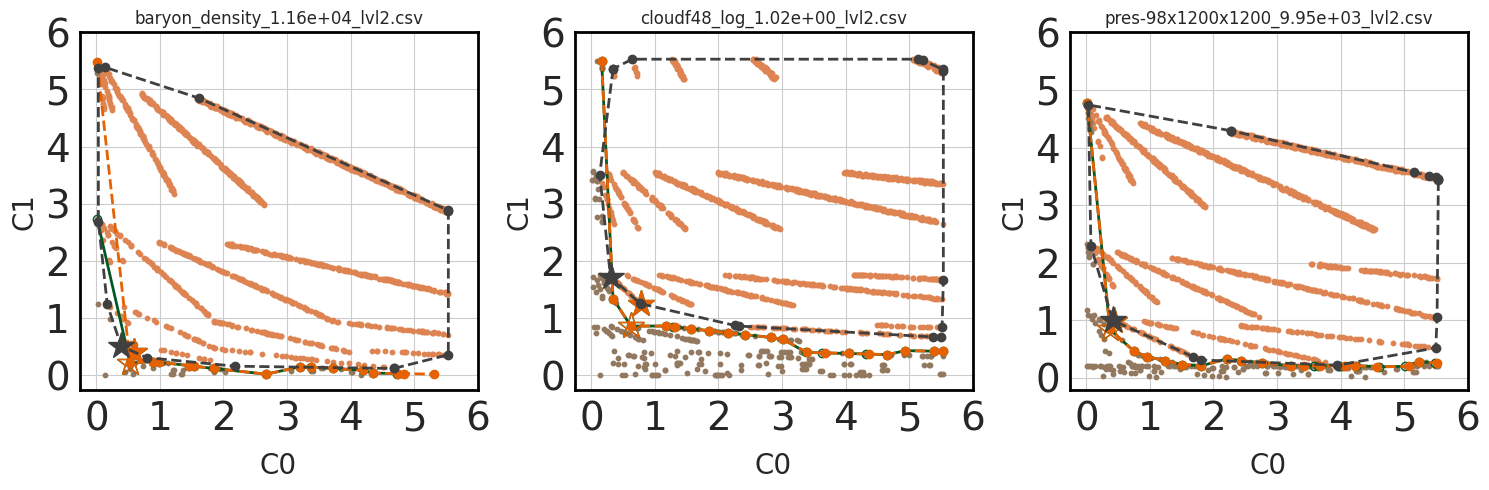

In [ ]:
# 2d plot
for t in range(0, 1): #len(Threshold)
    threshold = Threshold[t]

    plt.rcParams["figure.figsize"] = [15, 5]
    fig = plt.figure()

    # DATASETS
    for k in range(0, 3):
        time_path = Time_paths_lvl2[k]
        dname = time_path.split("/")[1]
        data0 = pd.read_csv(time_path).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        ax1 = fig.add_subplot(1, 3, k+1)
        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
        trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].Total_retrieve_size.values
        img1 = ax1.scatter(c0, c1, color=current_palette[1], alpha=1, s=10)
        points1 = np.vstack([c0, c1]).T

        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
        ax1.scatter(c0, c1, color=current_palette[5], alpha=1, s=10)
        points2 = np.vstack([c0, c1]).T

        # ax1.plot(Contour[:, 1], Contour[:, 2], '*', color="k", markersize=4)
        vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points2, points1, use_contour=True)
        ax1.plot(dx, dy, '*', color="#005824", markersize=20)
        ax1.plot(Vx, Vy, '*', color="#005824", markerfacecolor="None", markersize=20)
        ax1.plot(vx, vy, 'o', color="#005824", markerfacecolor="None")
        ax1.plot(vx, vy, '-', color="#005824", lw=2)

        # find the best in curve-miss points
        vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points2, points1, use_contour=False)
        ax1.plot(dx, dy, '*', color="#e66101", markersize=20)
        ax1.plot(Vx, Vy, '*', color="#e66101", markerfacecolor="None", markersize=20)
        ax1.plot(vx, vy, 'o', color="#e66101")
        ax1.plot(vx, vy, '--', color="#e66101", lw=2)

        # find the best in convex hull
        vx, vy, Vx, Vy = search_convex_hull_2d(points1)
        ax1.plot(Vx, Vy, '*', color="#404040", markersize=20)
        ax1.plot(vx, vy, 'o', color="#404040", )
        ax1.plot(vx, vy, '--',color="#404040", lw=2)

        ax1.set_title(dname)
        ax1.set_xlabel('C0', labelpad=10, fontsize=20)
        ax1.set_ylabel('C1', labelpad=5, fontsize=20)
        ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

        ax1.spines["bottom"].set_color("black")
        ax1.spines["top"].set_color("black")
        ax1.spines["right"].set_color("black")
        ax1.spines["left"].set_color("black")

    fig.tight_layout()
    fig.show()

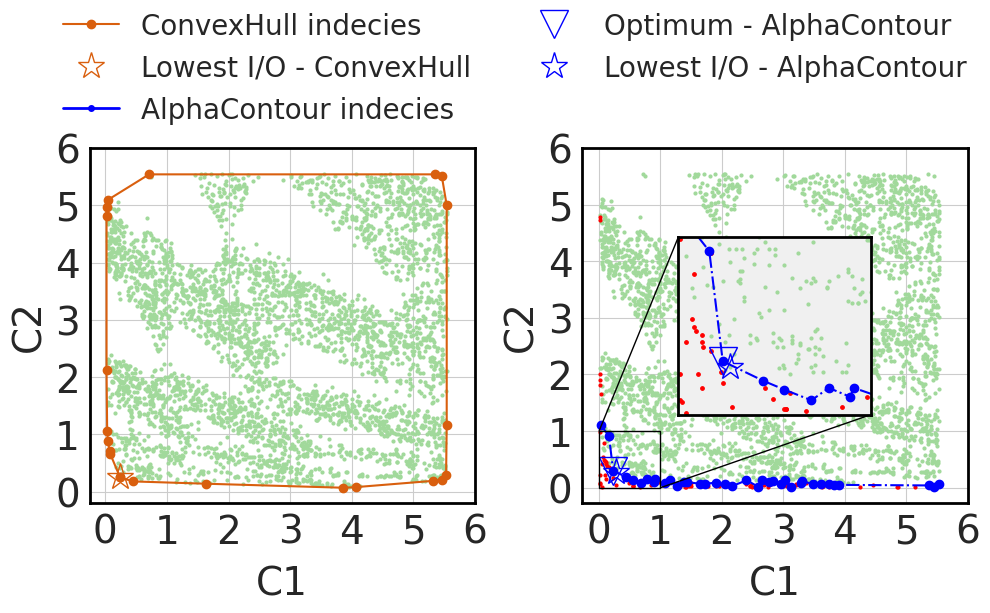

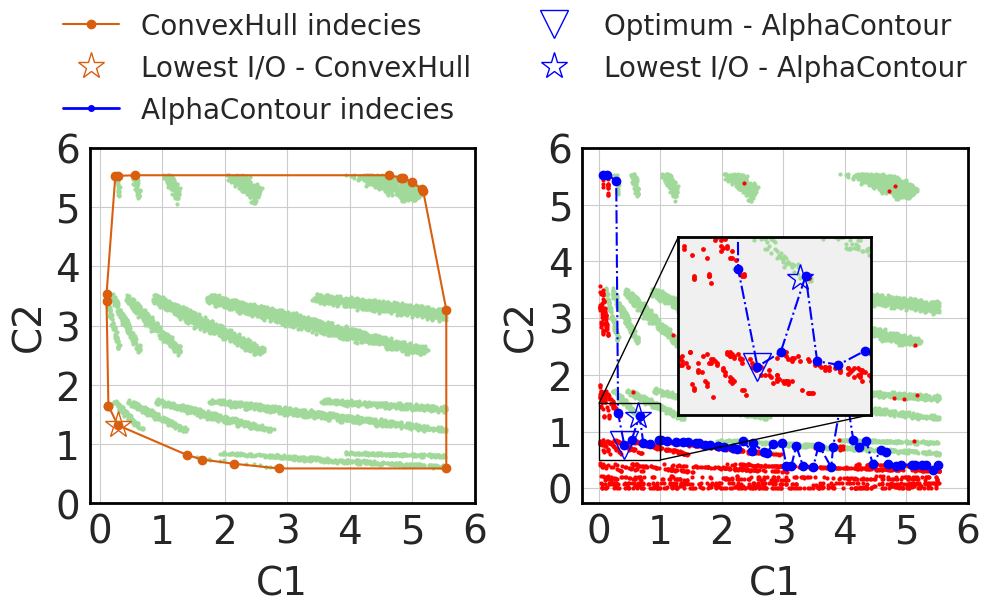

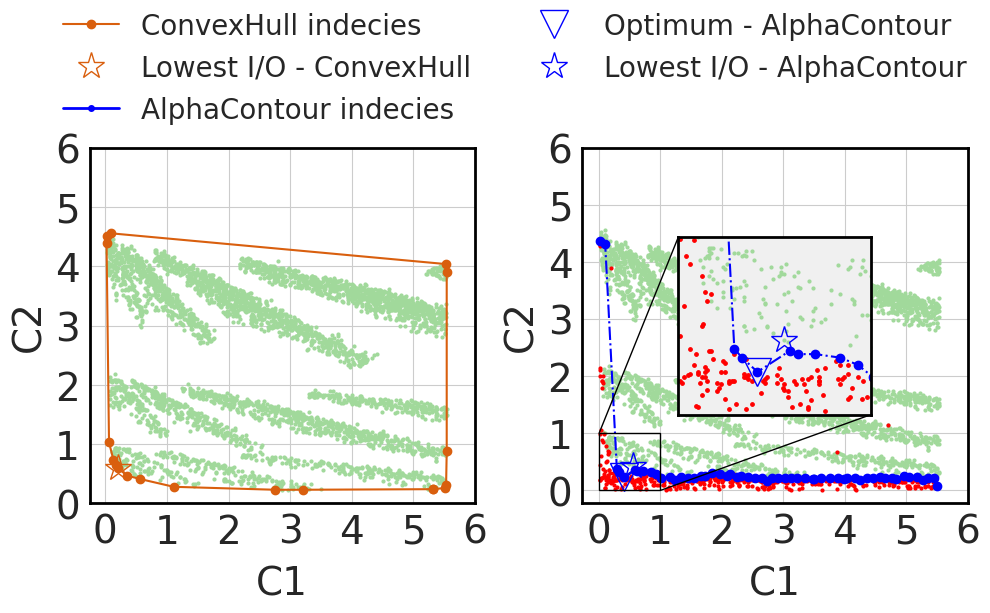

In [ ]:
# 3d plot
# Time_paths = ['datasets/cloudf48_log_1.01e-04.csv',
#               'datasets/pres-98x1200x1200_9.95e-01.csv',
#               'datasets/baryon_density_1.16e+00.csv']

Time_paths = Time_paths_lvl3

# Threshold = [0.03] #  0.03, 0.06, 0.09 0.2, 0.3, 0.4, 0.5, 0.6
threshold = 0.03

# DATASETS
for k in range(0, 3): #len(Time_paths)

    plt.rcParams["figure.figsize"] = [10, 5]
    fig = plt.figure()

    time_path = Time_paths[k]
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    # Code snippet to create inset axes.
    # axis is the surrounding axis into which the inset axis will be added
    # Create an inset axis in the bottom right corner
    axin = ax2.inset_axes([.25, .25, 0.5, 0.5])
    axin.set_facecolor("#f0f0f0")
    # ===============================================================================================
    c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
    c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
    c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
    points1 = np.vstack([c0, c1, c2]).T

    ax1.scatter(c1, c2, color="#a1d99b", alpha=1, s=4)
    ax2.scatter(c1, c2, color="#a1d99b", alpha=1, s=4)
    axin.scatter(c1, c2, color="#a1d99b", alpha=1, s=4)

    # find the best in convex hull
    vy, vz, Vy, Vz = search_convex_hull_2d(np.vstack([c1, c2]).T)
    ax1.plot(vy, vz, '-o', color="#d95f0e", label="ConvexHull indecies")
    ax1.plot(Vy, Vz, '*', color="#d95f0e", markerfacecolor="None", markersize=20, label="Lowest I/O - ConvexHull")

    # ===============================================================================================
    c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
    c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
    c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
    points2 = np.vstack([c0, c1, c2]).T

    ax2.scatter(c1, c2, color="red", s=4)
    axin.scatter(c1, c2, color="red", s=6)

    contour, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, use_contour=True)
    # ax2.scatter(contour[:, 1], contour[:, 2], color="blue", s=4, label="contour points")
    # ax1.plot(dy, dz, '*', color=current_palette[1], fillstyle="left", markeredgewidth=0.0, markersize=25, label="Lowest I/O - Contour")
    # ax1.plot(Vy, Vz, 'v', color=current_palette[1], markerfacecolor="None", markersize=20)
    ax2.plot(vy[0], vz[0], '-o', color="blue", markersize=4, lw=2, label="AlphaContour indecies")
    ax2.plot(vy, vz, 'o',  color="blue", )
    ax2.plot(vy, vz, '-.', color="blue", )
    ax2.plot(Vy, Vz, 'v',  color="blue", markersize=20, markerfacecolor="None", label="Optimum - AlphaContour")
    ax2.plot(dy, dz, '*',  color="blue", markersize=20, markerfacecolor="None", label="Lowest I/O - AlphaContour")

    axin.plot(vy, vz, 'o',  color="blue",)
    axin.plot(vy, vz, '-.', color="blue",)
    axin.plot(Vy, Vz, 'v',  color="blue", markersize=20, markerfacecolor="None", label="Optimum - AlphaContour")
    axin.plot(dy, dz, '*',  color="blue", markersize=20, markerfacecolor="None", label="Lowest I/O - AlphaContour")

    if k==0:
        axin.set_xlim(0, 1)
        axin.set_ylim(0, 1)
        # axin.set_xticks([0, 0.25, 0.5, 0.75, 1])
        # axin.set_yticks([0, 0.25, 0.5, 0.75, 1])
    elif k ==1:
        axin.set_xlim(0, 1)
        axin.set_ylim(0.5, 1.5)
        # axin.set_xticks([0, 0.25, 0.5, 0.75, 1])
        # axin.set_yticks([0.25, 0.5, 0.75, 1, 1.25])
    elif k==2:
        axin.set_xlim(0, 1)
        axin.set_ylim(0, 1)
        # axin.set_xticks([0, 0.25, 0.5, 0.75, 1])
        # axin.set_yticks([0, 0.25, 0.5, 0.75, 1])

    axin.set_xticks([])
    axin.set_yticks([])

    ax2.indicate_inset_zoom(axin, alpha=1, edgecolor="k")

    axin.spines["bottom"].set_color("black")
    axin.spines["top"].set_color("black")
    axin.spines["right"].set_color("black")
    axin.spines["left"].set_color("black")

    # # find the best in curve-miss points
    # vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, use_contour=False)
    # ax1.plot(dy, dz, '*', color=current_palette[2], fillstyle="right", markeredgewidth=0.0, markersize=25, label="Lowest I/O - Curve-missed")
    # ax1.plot(Vy, Vz, 's', color=current_palette[2], markerfacecolor="None", markersize=20, label="Inflection point - Curve-missed")
    # ax1.plot(vy, vz, 'o',  color=current_palette[2], markerfacecolor="None", )
    # ax1.plot(vy, vz, '--', color=current_palette[2], markersize=10, lw=3, label="Point-based")

    # ax1.text(6, 6, "Abs_Err={:.2e}".format(reqerr), fontsize=18, ha="right")
    # ax1.text(6, 6, "Threshold={}".format(threshold), fontsize=18, ha="right")
    # ax1.text(6, 5.2,   "Alpha={:.2}".format(alpha), fontsize=18, ha="right")

    # ax1.set_title(dname)
    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    # ax2.set_title(dname)
    ax2.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax2.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax2.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")
    # ax1.legend(frameon=True, fancybox=True, ncol=1, bbox_to_anchor=(1, 1), loc='upper right', fontsize=15)
    # ax2.legend(frameon=True, fancybox=True, ncol=1, bbox_to_anchor=(1, 1), loc='upper right', fontsize=15)

    fig.tight_layout()
    fig.show()
    fig.legend(frameon=False, fancybox=False, ncol=2, bbox_to_anchor=(.52, 1.1), loc='center', fontsize=20, borderpad=.1, labelspacing=.5)

    plt.savefig("{}_search_contour_3d.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), bbox_inches='tight', format="pdf")

In [ ]:
#

In [ ]:
# 4d plot
for t in range(0, 1): #len(Threshold)
    threshold = Threshold[t]

    plt.rcParams["figure.figsize"] = [15*1.2, 5*1.2]
    fig = plt.figure()

    # DATASETS
    for k in range(0, 3):
        time_path = Time_paths_lvl4[k]
        dname = time_path.split("/")[1]
        data0 = pd.read_csv(time_path).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        ax1 = fig.add_subplot(1, 3, k+1)
        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
        c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c3.values
        trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].Total_retrieve_size.values
        img1 = ax1.scatter(c2, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
        points1 = np.vstack([c0, c1, c2, c3]).T

        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
        c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c3.values
        ax1.scatter(c2, c3, color=current_palette[3], alpha=1, s=4)
        points2 = np.vstack([c0, c1, c2, c3]).T

        vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points2, points1, use_contour=True)
        ax1.plot(dz, dh, 's', color="#005824", markersize=10)
        ax1.plot(Vz, Vh, 's', color="#005824", markerfacecolor="None", markersize=10)
        ax1.plot(vz, vh, 'o', color="#005824", markerfacecolor="None")
        ax1.plot(vz, vh, '-', color="#005824", lw=2)

        # find the best in curve-miss points
        vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points2, points1, use_contour=False)
        ax1.plot(dz, dh, '*', color="#e66101", markersize=10)
        ax1.plot(Vz, Vh, '*', color="#e66101", markerfacecolor="None", markersize=10)
        ax1.plot(vz, vh, 'o', color="#e66101", markerfacecolor="None")
        ax1.plot(vz, vh, '--', color="#e66101", lw=2)

        # find the best in convex hull
        vx, vy, vz, vh, Vx, Vy, Vz, Vh = search_convex_hull_4d(points1)
        ax1.plot(Vz, Vh, '*', color="#404040", markersize=10)
        # ax1.plot(vz, vh, 'ko')

        ax1.set_title(dname)
        ax1.set_xlabel('C2', labelpad=10, fontsize=20)
        ax1.set_ylabel('C3', labelpad=5, fontsize=20)
        ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

        ax1.spines["bottom"].set_color("black")
        ax1.spines["top"].set_color("black")
        ax1.spines["right"].set_color("black")
        ax1.spines["left"].set_color("black")

    fig.tight_layout()
    fig.show()

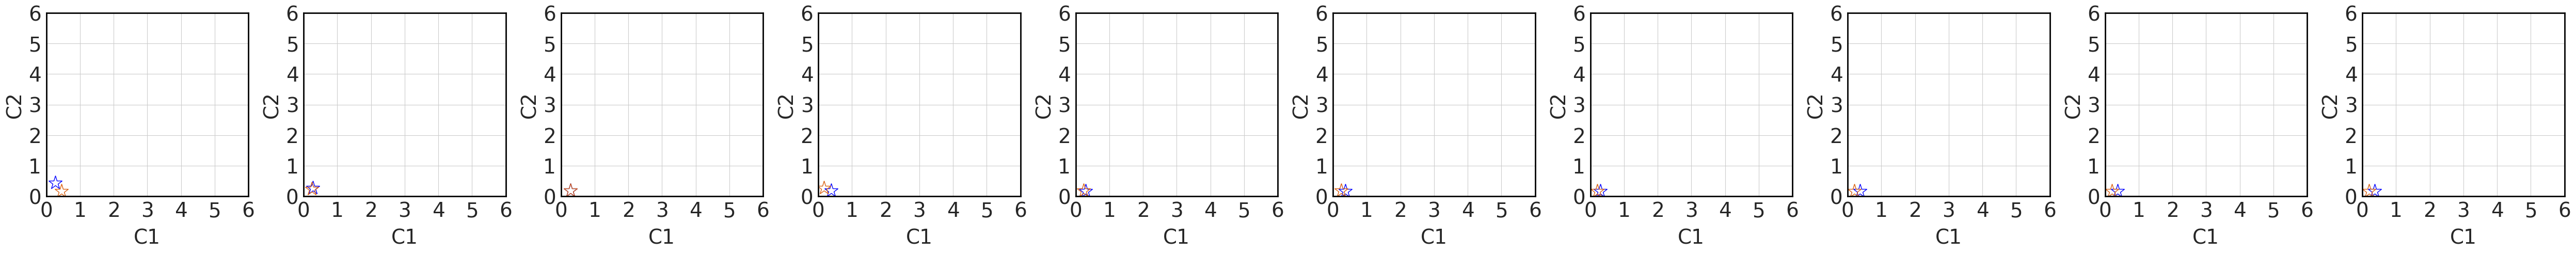

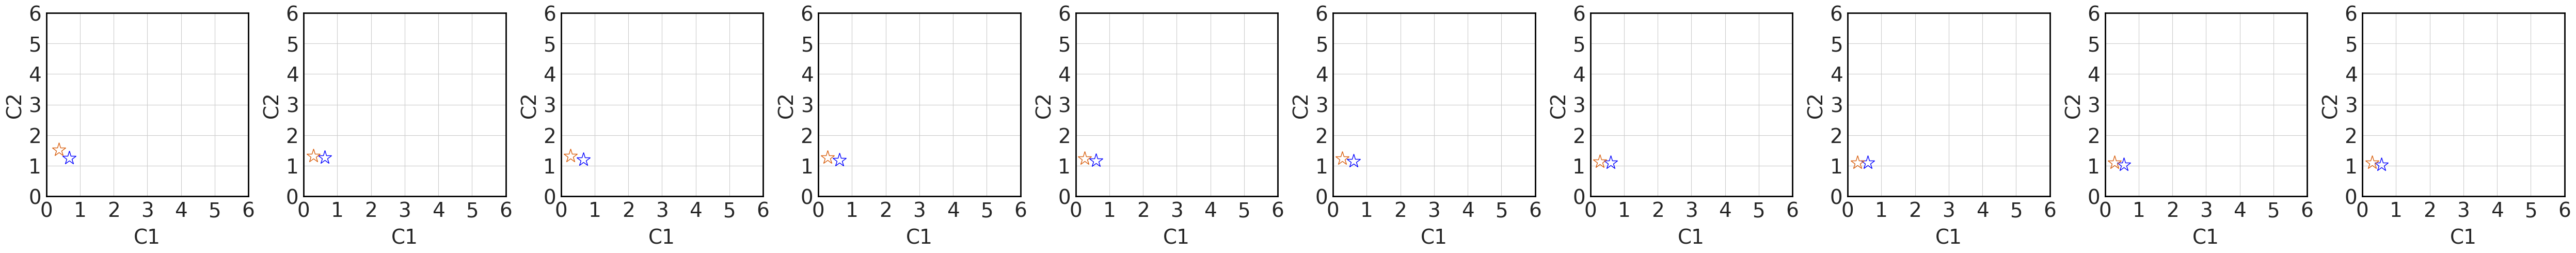

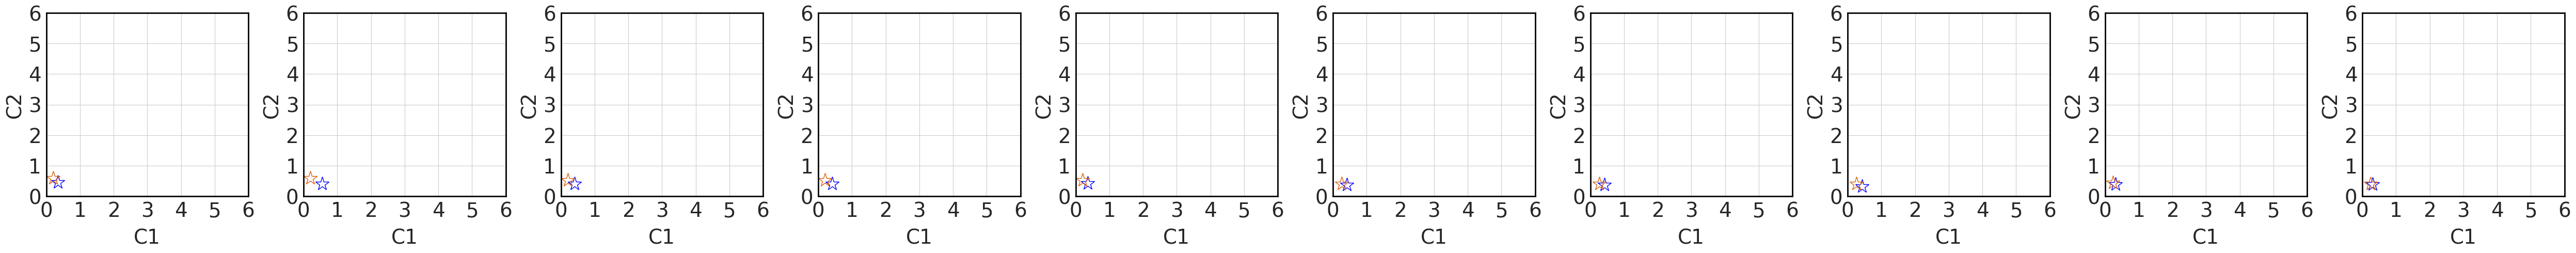

In [ ]:
time_path = ["datasets/cloudf48_log_1.01e-04.csv",
                  "datasets/cloudf48_log_1.02e-02.csv",
                  "datasets/cloudf48_log_1.02e+00.csv",
                  ]

# for time_path in ["datasets/baryon_density_1.16e+00.csv",
#                   "datasets/baryon_density_1.16e+02.csv",
#                   "datasets/baryon_density_1.16e+04.csv",
#                   ]:

# for time_path in ["datasets/pres-98x1200x1200_9.95e-01.csv",
#                   "datasets/pres-98x1200x1200_9.95e+01.csv",
#                   "datasets/pres-98x1200x1200_9.95e+03.csv",]:

Threshold = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19] #  0.03, 0.06, 0.09 0.2, 0.3, 0.4, 0.5, 0.6
# threshold = 0.03

for k in range(0, len(Time_paths)):
    # DATASETS
    time_path = Time_paths[k]
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    plt.rcParams["figure.figsize"] = [5*len(Threshold), 5]
    fig = plt.figure()

    for t in range(0, len(Threshold)): #len(Threshold)
        threshold = Threshold[t]

        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
        points1 = np.vstack([c0, c1, c2]).T

        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
        points2 = np.vstack([c0, c1, c2]).T

        ax1 = fig.add_subplot(1, len(Threshold), t+1)

        # search with contour of not-error-bounded data points
        contour, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, use_contour=True)
        iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
        maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
        ax1.plot(dy, dz, '*',  color="blue", markersize=20, markerfacecolor="None", label="Lowest I/O - AlphaContour")

        # search with convex hull of error-bounded data points
        vx, vy, vz, Vx, Vy, Vz = search_convex_hull_3d(points1)
        iosize = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz)].values[0]
        maxerr = data0.MaxErr[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz)].values[0]
        ax1.plot(Vy, Vz, '*',  color="#d95f0e", markersize=20, markerfacecolor="None", label="Lowest I/O - ConvexHull")

        ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
        ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
        ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

        ax1.spines["bottom"].set_color("black")
        ax1.spines["top"].set_color("black")
        ax1.spines["right"].set_color("black")
        ax1.spines["left"].set_color("black")

    fig.tight_layout()
    fig.show()
    # fig.legend(frameon=False, fancybox=False, ncol=2, bbox_to_anchor=(.52, 1.1), loc='center', fontsize=20, borderpad=.1, labelspacing=.5)

    # plt.savefig("{}_search_contour_3d.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), bbox_inches='tight', format="pdf")

In [ ]:
Time_paths_lvl3

['datasets/baryon_density_1.16e+04_lvl3.csv',
 'datasets/cloudf48_log_1.02e+00_lvl3.csv',
 'datasets/pres-98x1200x1200_9.95e+03_lvl3.csv']

## Traditonal optimization (deprecated)

### optimization with simulated annealing

- we have 3 parameter to search in total: c0, c1, c2;

In [ ]:
# import math
# import random

# # def loss_function(x, y):
# #     # Rosenbrock function
# #     return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

# def loss_function(data, c0, c1, c2):
#     # print(c0)
#     c1 = 5.54
#     c2 = 5.54
#     medata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].MaxErr.values[0]
#     redata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Requested_tolerance.values[0]
#     trsdata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Total_retrieve_size.values[0]
#     # return np.abs(medata - redata)*trsdata
#     return relu(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata)

# def acceptance_probability(current_loss, neighbor_loss, temperature):
#     if neighbor_loss < current_loss:
#         return 1.0
#     return math.exp((current_loss - neighbor_loss) / temperature)

# def simulated_annealing_optimizer(data):
#     # Initial solution
#     # current_solution = [np.random.randint(1, 554 + 1)/100, np.random.randint(1, 554 + 1)/100, np.random.randint(1, 554 + 1)/100]
#     # current_solution = [np.random.randint(1, 554 + 1)/100, 5.54, 5.54]
#     current_solution = [.5, 5.54, 5.54]
#     best_solution = current_solution

#     # Parameters
#     initial_temperature = 10000000000000000.0
#     final_temperature = 0.01
#     cooling_rate = 0.3

#     # Start annealing process
#     temperature = initial_temperature
#     while temperature > final_temperature:
#         # Generate a neighboring solution
#         # neighbor = [current_solution[0] + np.random.randint(-1, 2)/100,
#         #             current_solution[1] + np.random.randint(-1, 2)/100,
#         #             current_solution[2] + np.random.randint(-1, 2)/100]
#         neighbor = [np.round(current_solution[0] + np.random.randint(-1, 2)/100, 2),
#                     5.54,
#                     5.54]

#         if neighbor[0] > 5.54:
#             neighbor[0] = 5.54
#         if neighbor[0] < 0.01:
#             neighbor[0] = 0.01

#         # Calculate the loss for the current and neighboring solutions
#         current_loss = loss_function(data, current_solution[0], current_solution[1], current_solution[2])
#         neighbor_loss = loss_function(data, neighbor[0], neighbor[1], neighbor[2])

#         print(current_solution, temperature, current_loss)

#         # Decide whether to move to the neighboring solution
#         if random.random() < acceptance_probability(current_loss, neighbor_loss, temperature):
#             current_solution = neighbor

#         # Update the best solution
#         if loss_function(data, current_solution[0], current_solution[1], current_solution[2]) < loss_function(data, best_solution[0], best_solution[1], best_solution[2]):
#             best_solution = current_solution

#         # Cool down the temperature
#         temperature *= (1 - cooling_rate)

#     return best_solution

# # Usage
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format("1e-5"))).drop_duplicates()

# best_solution = simulated_annealing_optimizer(data0)
# best_loss = loss_function(data0, best_solution[0], best_solution[1], best_solution[2])

# print("Best solution:", best_solution)
# print("Loss:", best_loss)


In [ ]:
# data = data0
# c0 = 0.2
# c1 = 5.54
# c2 = 5.54
# medata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].MaxErr.values[0]
# redata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Requested_tolerance.values[0]
# trsdata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Total_retrieve_size.values[0]
# print(medata, redata, trsdata, np.abs(medata - redata)*trsdata)

### optimization with genetic algorithm

- we have 3 parameter to search in total: c0, c1, c2;

In [ ]:
# import math
# import random

# def loss_function(data, c0, c1, c2):
#     # print(c0, c1, c2)
#     medata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].MaxErr.values[0]
#     redata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Requested_tolerance.values[0]
#     trsdata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Total_retrieve_size.values[0]
#     # return np.abs(medata - redata)*trsdata
#     return relu(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata)

# def generate_initial_population(population_size):
#     # Generate an initial population of random solutions
#     population = []
#     for _ in range(population_size):
#         solution = [np.random.randint(1, 554 + 1)/100, 5.54, 5.54]
#         population.append(solution)
#     return population

# def select_parents(data, population, num_parents):
#     # Select the best parents from the population based on their fitness
#     population = sorted(population, key=lambda x: loss_function(data, x[0], x[1], x[2]))
#     parents = population[:num_parents]
#     return parents

# def crossover(parents, num_offspring):
#     # Perform crossover to generate offspring
#     offspring = []
#     for _ in range(num_offspring):
#         parent1, parent2 = random.sample(parents, 2)
#         child = [parent1[0], parent2[1], parent1[2]]  # Example crossover operation
#         offspring.append(child)
#     return offspring

# def mutate(offspring, mutation_rate):
#     # Perform mutation on the offspring
#     for child in offspring:
#         if random.random() < mutation_rate:
#             # child[0] += random.uniform(-1, 1)  # Example mutation operation
#             child[0] = np.round(child[0] + np.random.randint(-1, 2)/100, 2)
#             # child[1] += random.uniform(-1, 1)  # Example mutation operation

#         if child[0] > 5.54:
#             child[0] = 5.54
#         if child[0] < 0.01:
#             child[0] = 0.01
#     return offspring

# def genetic_algorithm_optimizer(data):
#     # Parameters
#     population_size = 100
#     num_generations = 100
#     num_parents = 20
#     num_offspring = population_size - num_parents
#     mutation_rate = 0.1

#     # Generate initial population
#     population = generate_initial_population(population_size)

#     # Start evolution process
#     for _ in range(num_generations):
#         # Select parents
#         parents = select_parents(data, population, num_parents)

#         # Perform crossover
#         offspring = crossover(parents, num_offspring)
#         # print(offspring)

#         # Perform mutation
#         offspring = mutate(offspring, mutation_rate)

#         # Create the new population
#         population = parents + offspring

#     # Select the best solution from the final population
#     best_solution = min(population, key=lambda x: loss_function(data, x[0], x[1], x[2]))

#     return best_solution

# # Usage
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format("1e-5"))).drop_duplicates()

# best_solution = genetic_algorithm_optimizer(data0)
# best_loss = loss_function(data0, best_solution[0], best_solution[1], best_solution[2])

# print("Best solution:", best_solution)
# print("Loss:", best_loss)


In [ ]:
# Best solution: [0.02, 5.54, 5.54]
# Loss: 26174.775165000017

# Best solution: [0.09, 5.54, 5.54]
# Loss: 156678.359454

In [ ]:
# def relu(x):
#     return max(0, x)

# def relu_array(input_array):
#     return [relu(x) for x in input_array]

In [ ]:
# relu_array([-1, 1, 2, -2])

## MLP for mapping factor prediction (moved to DNN_Mgard_train.ipynb)

In [ ]:
# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.utils.data as Data
# from torch.autograd import Variable
# from torch.optim import *

# import copy
# from sklearn import preprocessing

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# import random
# random.seed(10)

In [ ]:
# # correlation
# traintest_data = pd.read_csv("traintest_3d_convex.csv")
# traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values

# # target_feature  = traintest_data[["relerr", "reqerr", "threshold", "c0", "c1", "c2"]].copy()

# # plt.figure(figsize=(5, 5))
# # ticklabels = ["relerr", "reqerr", "threshold", "c0", "c1", "c2"]
# # heatmap = sns.heatmap(target_feature.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":10}, yticklabels=ticklabels, xticklabels=ticklabels)
# # sns.set(font_scale=1)
# # cbar = heatmap.collections[0].colorbar
# # cbar.ax.tick_params(labelsize=15)

# dnames = ["cloudf48_log", "precipf48_log", "qgraupf48_log", "qicef48_log",
#           "baryon_density", "dark_matter_density", "temperature", "velocity_x",
#           "pres-98x1200x1200", "qc-98x1200x1200", "qg-98x1200x1200","qi-98x1200x1200",]

# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(len(dnames)):

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     drange = data.drange.values
#     c0 = data.c0.values
#     c1 = data.c1.values
#     c2 = data.c2.values

#     ax1 = fig1.add_subplot(3, 4, i+1)
#     # ax1.plot(np.arange(len(c0)), c0, label="{}-c0".format(dname))
#     # ax1.plot(np.arange(len(c1)), c1, label="{}-c1".format(dname))
#     ax1.plot(np.arange(len(c2)), c2, label="{}-c2".format(dname))

#     ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#     ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#     ax1.text(120, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
#     ax1.text(120, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="right")

In [ ]:
# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(3):

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     threshold = data.threshold.values
#     reqerr = data.reqerr.values

#     ax1 = fig1.add_subplot(3, 4, i+1)
#     # ax1.plot(np.arange(len(threshold)), threshold)
#     ax1.plot(np.arange(len(reqerr)), reqerr)
#     ax1.set_yscale("log")

In [ ]:
# def preprocess(traintest_data, num_lvl, split_ratio=0.2, shuffle=True):

#     df_data_feature = traintest_data[["relerr", "reqerr", "threshold"]].copy()
#     df_data_target  = traintest_data[["c2"]].copy()

#     # if num_lvl == 2:
#     #     df_data_target  = traintest_data[["c0", "c1"]].copy()
#     # elif num_lvl == 3:
#     #     df_data_target  = traintest_data[["c0", "c1", "c2"]].copy()
#     # elif num_lvl == 4:
#     #     df_data_target  = traintest_data[["c0", "c1", "c2", "c3"]].copy()

#     data_feature  = np.array(df_data_feature.astype("float32"))
#     data_target   = np.array(df_data_target.astype("float32"))

#     X_train, X_test, Y_train, Y_test = train_test_split(data_feature, data_target, test_size=split_ratio,
#                                                         shuffle=shuffle, random_state=233)

#     normalizer = preprocessing.Normalizer()
#     normalized_train_X = normalizer.fit_transform(X_train)
#     normalized_test_X  = normalizer.transform(X_test)

#     return normalized_train_X, normalized_test_X, Y_train, Y_test

# traintest_data = pd.read_csv("traintest_3d_convex.csv")
# traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values
# traintest_data = traintest_data[traintest_data['dname'].str.contains('cloudf48')]
# normalized_train_X, normalized_test_X, Y_train, Y_test = preprocess(traintest_data, num_lvl=3, split_ratio=0.2, shuffle=False)

In [ ]:
# class MLP(torch.nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()

#         self.model1 = torch.nn.Sequential(
#             torch.nn.Linear(3, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 1),
#         )

#         self.model2 = torch.nn.Sequential(
#             torch.nn.Linear(2, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 2),
#         )

#         self.model3 = torch.nn.Sequential(
#             torch.nn.Linear(2, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 3),
#         )

#         self.model4 = torch.nn.Sequential(
#             torch.nn.Linear(2, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 4),
#         )

#     def forward(self, x):
#         output = self.main(x)
#         return output

# class MyLoss(nn.Module):
#     def __init__(self):
#         super(MyLoss, self).__init__()

#     def forward(self, prediction, target):
#         loss = torch.nn.L1Loss()(prediction, target)
#         return loss

In [ ]:

# def train(X_train, Y_train, num_lvl, num_epoch, learning_rate):
#     x_train = Variable(torch.from_numpy(X_train))
#     y_train = Variable(torch.from_numpy(Y_train))

#     net = MLP().model1
#     # if num_lvl == 2:
#     #     net = MLP().model2
#     # elif num_lvl == 3:
#     #     net = MLP().model3
#     # elif num_lvl == 4:
#     #     net = MLP().model4

#     print(net)
#     net = net.to("cuda")

#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#     loss_func = MyLoss()

#     BATCH_SIZE = 64
#     EPOCH = num_epoch

#     torch_dataset = Data.TensorDataset(x_train, y_train)

#     loader = Data.DataLoader(
#         dataset=torch_dataset,
#         batch_size=BATCH_SIZE,
#         shuffle=True, num_workers=4,)

#     # start training
#     print("Training: model{}".format(num_lvl))
#     for epoch in range(EPOCH):
#         for step, (batch_x, batch_y) in enumerate(loader): # for each training step
#             b_x = Variable(batch_x)
#             b_y = Variable(batch_y)
#             b_x = b_x.to("cuda")
#             b_y = b_y.to("cuda")
#             prediction = net(b_x)     # input x and predict based on x
#             loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
#             optimizer.zero_grad()   # clear gradients for next train
#             loss.backward()         # backpropagation, compute gradients
#             optimizer.step()        # apply gradients

#         if epoch % 100 == 0:
#             # print(loss.detach().numpy())
#             print(loss.to("cpu").detach().numpy())
#     return net

In [ ]:
# def inference(feature, net, target):
#     feature = Variable(torch.from_numpy(feature))
#     target = Variable(torch.from_numpy(target))

#     feature = feature.to("cuda")
#     target = target.to("cuda")
#     prediction = net(feature)
#     return target.to("cpu").detach().numpy(), prediction.to("cpu").detach().numpy()

In [ ]:
# def validate_var(net, dname):
#     traintest_data = pd.read_csv("traintest_3d_convex.csv")
#     traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values
#     traintest_data = traintest_data[traintest_data['dname'].str.contains(dname)]
#     X_train, X_test, Y_train, Y_test = preprocess(traintest_data, num_lvl=3, split_ratio=0.9, shuffle=False)
#     target, prediction = inference(X_test, net, Y_test)

#     return target, prediction

# # validate_var(net)

In [ ]:
# if __name__ == "__main__":
#     # the main starts here
#     traintest_data = pd.read_csv("traintest_3d_convex.csv")
#     # traintest_data = traintest_data[traintest_data['dname'].str.contains('cloudf48_log')]
#     X_train, X_test, Y_train, Y_test = preprocess(traintest_data, num_lvl=3, split_ratio=0.1, shuffle=False)

#     print(np.shape(X_train), np.shape(Y_train), np.shape(X_test), np.shape(Y_test))
#     net = train(X_train, Y_train, num_lvl=3, num_epoch=3200, learning_rate=0.0001)

In [ ]:
# dnames = ["cloudf48_log", "precipf48_log", "qgraupf48_log", "qicef48_log",
#           "baryon_density", "dark_matter_density", "temperature", "velocity_x",
#           "pres-98x1200x1200", "qc-98x1200x1200", "qg-98x1200x1200","qi-98x1200x1200",]

# traintest_data = pd.read_csv("traintest_3d_convex.csv")
# traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values

# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(4): # len(dnames)

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.2, shuffle=False)
#     net = train(X_train, Y_train, num_lvl=3, num_epoch=1200, learning_rate=0.01)

#     target, prediction = validate_var(net, dname)

#     # drange = data.drange.values
#     # c0 = data.c0.values
#     # c1 = data.c1.values
#     # c2 = data.c2.values

#     ax1 = fig1.add_subplot(3, 4, i+1)
#     # ax1.plot(np.arange(len(c0)), c0, label="{}-c0".format(dname))
#     # ax1.plot(np.arange(len(c1)), c1, label="{}-c1".format(dname))
#     # ax1.plot(np.arange(len(c2)), c2, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(target)), target, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(prediction)), prediction, label="{}-c2".format(dname))

#     ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#     ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#     ax1.text(120, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
#     ax1.text(120, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="right")

In [ ]:
# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(4, len(dnames)): # len(dnames)

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.2, shuffle=False)
#     net = train(X_train, Y_train, num_lvl=3, num_epoch=1200, learning_rate=0.01)

#     target, prediction = validate_var(net, dname)

#     # drange = data.drange.values
#     # c0 = data.c0.values
#     # c1 = data.c1.values
#     # c2 = data.c2.values

#     ax1 = fig1.add_subplot(3, 4, i-3)
#     # ax1.plot(np.arange(len(c0)), c0, label="{}-c0".format(dname))
#     # ax1.plot(np.arange(len(c1)), c1, label="{}-c1".format(dname))
#     # ax1.plot(np.arange(len(c2)), c2, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(target)), target, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(prediction)), prediction, label="{}-c2".format(dname))

#     ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#     ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#     ax1.text(120, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
#     ax1.text(120, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="right")

## Misc

In [ ]:
# def plot_various(time_path, relerr):
#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 9])
#     ax1 = fig.add_subplot(331)
#     ax2 = fig.add_subplot(332)
#     ax3 = fig.add_subplot(333)
#     ax4 = fig.add_subplot(334)
#     ax5 = fig.add_subplot(335)
#     ax6 = fig.add_subplot(336)
#     ax7 = fig.add_subplot(337)
#     ax8 = fig.add_subplot(338)
#     ax9 = fig.add_subplot(339)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     ax1.plot(xdata, trsdata, "s", markersize=2, color=current_palette[0], label="Retrieved size")
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Retrieval size", fontsize=fontsize)

#     # ax2.plot(np.linspace(0, 6, 1000), [.8]*1000, "s", markersize=1, color="gray")
#     ax2.plot(xdata, eedata, "s", markersize=2, color=current_palette[0], label="Estimated")
#     ax2x = ax2.twinx()
#     ax2x.plot(xdata, medata, "s", markersize=2, color=current_palette[1], label="Achieved")
#     # ax2x.set_ylim(0, 100)
#     ax2.set_xlabel("C0", fontsize=fontsize)
#     ax2.set_ylabel("Esti'd error", fontsize=fontsize)

#     ax3.plot(xdata, eedata/xdata, "s", markersize=2, color=current_palette[2], label="Error gradient")
#     ax3.set_yscale("log")
#     ax3.set_xlabel("C0", fontsize=fontsize)
#     ax3x = ax3.twinx()
#     ax3x.plot(xdata, 1/l0, linewidth=2, label="Reciprocal of bit plane number")

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     ax4.plot(ydata, trsdata, "s", markersize=2, color=current_palette[0], label="Retrieved size")
#     ax4.set_xlabel("C1", fontsize=fontsize)
#     ax4.set_ylabel("Retrieval size", fontsize=fontsize)

#     # ax5.plot(np.linspace(0, 6, 1000), [.8]*1000, "s", markersize=1, color="gray")
#     ax5.plot(ydata, eedata, "s", markersize=2, color=current_palette[0], label="Estimated")
#     ax5x = ax5.twinx()
#     ax5x.plot(ydata, medata, "s", markersize=2, color=current_palette[1], label="Achieved")
#     # ax5x.set_ylim(0, 100)
#     ax5.set_xlabel("C1", fontsize=fontsize)
#     ax5.set_ylabel("Compr'n error", fontsize=fontsize)

#     ax6.plot(ydata, eedata/ydata, "s", markersize=2, color=current_palette[2], label="Error gradient")
#     ax6.set_yscale("log")
#     ax6.set_xlabel("C1", fontsize=fontsize)
#     ax6x = ax6.twinx()
#     ax6x.plot(ydata, 1/l1, linewidth=2, label="Reciprocal of bit plane number")

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     ax7.plot(zdata, trsdata, "o", markersize=2, color=current_palette[0], label="Retrieved size")
#     ax7.set_xlabel("C2", fontsize=fontsize)
#     ax7.set_ylabel("Retrieval size", fontsize=fontsize)

#     # ax8.plot(np.linspace(0, 6, 1000), [.8]*1000, "s", markersize=1, color="gray")
#     ax8.plot(zdata, eedata, "s", markersize=2, color=current_palette[0], label="Estimated")
#     ax8x = ax8.twinx()
#     ax8x.plot(zdata, medata, "s", markersize=2, color=current_palette[1], label="Achieved")
#     # ax8x.set_ylim(0, 100)
#     ax8.set_xlabel("C2", fontsize=fontsize)
#     ax8.set_ylabel("Compr'n error", fontsize=fontsize)

#     ax9.plot(zdata, eedata/zdata, "s", markersize=2, color=current_palette[2], label="Error gradient")
#     ax9.set_yscale("log")
#     ax9.set_xlabel("C2", fontsize=fontsize)
#     ax9x = ax9.twinx()
#     ax9x.plot(zdata, 1/l2, linewidth=2, label="Reciprocal of bit plane number")

#     ax1.set_xticks(np.arange(0, 7))
#     ax2.set_xticks(np.arange(0, 7))
#     ax3.set_xticks(np.arange(0, 7))
#     ax4.set_xticks(np.arange(0, 7))
#     ax5.set_xticks(np.arange(0, 7))
#     ax6.set_xticks(np.arange(0, 7))
#     ax7.set_xticks(np.arange(0, 7))
#     ax8.set_xticks(np.arange(0, 7))
#     ax9.set_xticks(np.arange(0, 7))

#     ax1.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax2.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax3.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax4.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax5.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax6.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax7.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax8.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax9.set_xticklabels(np.arange(0, 7), fontsize=fontsize)

#     # ax2.set_ylim(55, 85)
#     # ax5.set_ylim(55, 85)
#     # ax8.set_ylim(55, 80)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")


#     #
#     # ax1.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .2), loc='center', fontsize=15)
#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .2), loc='center', fontsize=15)
#     # ax5.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .2), loc='center', fontsize=15)

#     # ax2.legend(frameon=False, ncol=1, bbox_to_anchor=(.8, .2), loc='right', fontsize=15)
#     # ax4.legend(frameon=False, ncol=1, bbox_to_anchor=(.8, .2), loc='right', fontsize=15)
#     # ax6.legend(frameon=False, ncol=1, bbox_to_anchor=(.8, .2), loc='right', fontsize=15)

#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(1, .2), loc='right', fontsize=15)
#     # ax6.legend(frameon=False, ncol=1, bbox_to_anchor=(1, .2), loc='right', fontsize=15)
#     # ax9.legend(frameon=False, ncol=1, bbox_to_anchor=(1, .2), loc='right', fontsize=15)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     # ax2.spines["bottom"].set_color("black")
#     # ax2.spines["top"].set_color("black")
#     # ax2.spines["right"].set_color("black")
#     # ax2.spines["left"].set_color("black")

#     # ax3.spines["bottom"].set_color("black")
#     # ax3.spines["top"].set_color("black")
#     # ax3.spines["right"].set_color("black")
#     # ax3.spines["left"].set_color("black")

#     ax4.spines["bottom"].set_color("black")
#     ax4.spines["top"].set_color("black")
#     ax4.spines["right"].set_color("black")
#     ax4.spines["left"].set_color("black")

#     # ax5.spines["bottom"].set_color("black")
#     # ax5.spines["top"].set_color("black")
#     # ax5.spines["right"].set_color("black")
#     # ax5.spines["left"].set_color("black")

#     # ax6.spines["bottom"].set_color("black")
#     # ax6.spines["top"].set_color("black")
#     # ax6.spines["right"].set_color("black")
#     # ax6.spines["left"].set_color("black")

#     ax7.spines["bottom"].set_color("black")
#     ax7.spines["top"].set_color("black")
#     ax7.spines["right"].set_color("black")
#     ax7.spines["left"].set_color("black")

#     ax2x.spines["bottom"].set_color("black")
#     ax2x.spines["top"].set_color("black")
#     ax2x.spines["left"].set_color("black")
#     ax2x.spines["right"].set_color("black")

#     ax5x.spines["bottom"].set_color("black")
#     ax5x.spines["top"].set_color("black")
#     ax5x.spines["left"].set_color("black")
#     ax5x.spines["right"].set_color("black")

#     ax8x.spines["bottom"].set_color("black")
#     ax8x.spines["top"].set_color("black")
#     ax8x.spines["left"].set_color("black")
#     ax8x.spines["right"].set_color("black")

#     ax3x.spines["bottom"].set_color("black")
#     ax3x.spines["top"].set_color("black")
#     ax3x.spines["left"].set_color("black")
#     ax3x.spines["right"].set_color("black")

#     ax6x.spines["bottom"].set_color("black")
#     ax6x.spines["top"].set_color("black")
#     ax6x.spines["left"].set_color("black")
#     ax6x.spines["right"].set_color("black")

#     ax9x.spines["bottom"].set_color("black")
#     ax9x.spines["top"].set_color("black")
#     ax9x.spines["left"].set_color("black")
#     ax9x.spines["right"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/Nyx_baryon_density"
# plot_various(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_various(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "ex")
# plot_various(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "jx")
# plot_various(time_path, "1e-1")

In [ ]:
# def plot_Error(time_path, relerr):

#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 3])
#     ax1 = fig.add_subplot(131)
#     ax2 = fig.add_subplot(132)
#     ax3 = fig.add_subplot(133)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     ax1.plot(xdata, medata, markersize=2, color=current_palette[0], marker="s", alpha=.5, label="c0_maxerror")
#     ax1.plot(xdata, eedata, markersize=2, color=current_palette[1], marker="s", alpha=.5, label="c0_estierror")

#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     ax2.plot(ydata, medata, markersize=2, color=current_palette[0], marker="s", alpha=.5, label="c1_maxerror")
#     ax2.plot(ydata, eedata, markersize=2, color=current_palette[1], marker="s", alpha=.5, label="c1_estierror")

#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     ax3.plot(zdata, medata, markersize=2, color=current_palette[0], marker="s", alpha=.5, label="c2_maxerror")
#     ax3.plot(zdata, eedata, markersize=2, color=current_palette[1], marker="s", alpha=.5, label="c2_estierror")
#     # ax1.set_xlabel("time_02_bx", fontsize=fontsize)
#     # ax1.set_ylabel("Error", fontsize=fontsize)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/Nyx_baryon_density"
# plot_Error(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_Error(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "ex")
# plot_Error(time_path)

# time_path = "datasets/time_00{}0_{}".format("30", "jx")
# plot_Error(time_path)

In [ ]:
# def plot_IO(time_path, relerr):

#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 9])
#     ax1 = fig.add_subplot(331)
#     ax2 = fig.add_subplot(332)
#     ax3 = fig.add_subplot(333)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     # print(trsdata[0:10])
#     ax1.plot(xdata, trsdata, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data10, sort=True)
#     # # print(trsdata[0:10])
#     # ax1.plot(xdata, trsdata, markersize=1, color=current_palette[1], marker="^", alpha=.3, label="30_bx")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data20, sort=True)
#     # # print(trsdata[0:10])
#     # ax1.plot(xdata, trsdata, markersize=1, color=current_palette[2], marker="^", alpha=.3, label="30_ex")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data30, sort=True)
#     # # print(trsdata[0:10])
#     # ax1.plot(xdata, trsdata, markersize=1, color=current_palette[3], marker="^", alpha=.3, label="30_jx")
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Retrieval size", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     ax2.plot(ydata, trsdata, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data11, sort=True)
#     # ax2.plot(ydata, trsdata, markersize=1, color=current_palette[1], marker="^", alpha=.3, label="30_bx")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data21, sort=True)
#     # ax2.plot(ydata, trsdata, markersize=1, color=current_palette[2], marker="^", alpha=.3, label="30_ex")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data31, sort=True)
#     # ax2.plot(ydata, trsdata, markersize=1, color=current_palette[3], marker="^", alpha=.3, label="30_jx")
#     ax2.set_xlabel("C1", fontsize=fontsize)
#     ax2.set_ylabel("Retrieval size", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     ax3.plot(zdata, trsdata, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data12, sort=True)
#     # ax3.plot(zdata, trsdata, markersize=1, color=current_palette[1], marker="^", alpha=.3, label="30_bx")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data22, sort=True)
#     # ax3.plot(zdata, trsdata, markersize=1, color=current_palette[2], marker="^", alpha=.3, label="30_ex")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data32, sort=True)
#     # ax3.plot(zdata, trsdata, markersize=1, color=current_palette[3], marker="^", alpha=.3, label="30_jx")
#     ax3.set_xlabel("C2", fontsize=fontsize)
#     ax3.set_ylabel("Retrieval size", fontsize=fontsize)

#     ax1.set_xticks(np.arange(0, 7))
#     ax2.set_xticks(np.arange(0, 7))
#     ax3.set_xticks(np.arange(0, 7))
#     ax1.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax2.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax3.set_xticklabels(np.arange(0, 7), fontsize=fontsize)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")

#     #
#     # ax1.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax2.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_IO(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_IO(time_path, "1e-3")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_IO(time_path, "1e-5")

In [ ]:
# def plot_BP(time_path, relerr):

#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates().sort_values(by="c0")
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates().sort_values(by="c1")
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates().sort_values(by="c2")

#     fig = plt.figure(figsize=[16, 9])
#     ax1 = fig.add_subplot(331)
#     ax2 = fig.add_subplot(332)
#     ax3 = fig.add_subplot(333)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0)
#     ax1.plot(xdata, l0, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax1.plot(xdata, l1, markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax1.plot(xdata, l2, markersize=2, color=current_palette[2], marker="^", alpha=.5)
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Num. of Bitplanes", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1)
#     ax2.plot(ydata, l0, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax2.plot(ydata, l1, markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax2.plot(ydata, l2, markersize=2, color=current_palette[2], marker="^", alpha=.5)
#     ax2.set_xlabel("C1", fontsize=fontsize)
#     ax2.set_ylabel("Num. of Bitplanes", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2)
#     ax3.plot(zdata, l0, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax3.plot(zdata, l1, markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax3.plot(zdata, l2, markersize=2, color=current_palette[2], marker="^", alpha=.5)
#     ax3.set_xlabel("C2", fontsize=fontsize)
#     ax3.set_ylabel("Num. of Bitplanes", fontsize=fontsize)

#     ax1.set_xticks(np.arange(0, 7))
#     ax2.set_xticks(np.arange(0, 7))
#     ax3.set_xticks(np.arange(0, 7))
#     ax1.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax2.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax3.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     #
#     # ax1.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax2.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_BP(time_path, "1e-1")
# plot_BP(time_path, "1e-3")
# plot_BP(time_path, "1e-5")

In [ ]:
# def relu(x):
#     return max(0, x)

# def relu_array(input_array):
#     return [relu(x) for x in input_array]

In [ ]:
# def plot_Loss(time_path, relerr):
#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()
#     data3 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_full.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 3])
#     ax1 = fig.add_subplot(141)
#     ax2 = fig.add_subplot(142)
#     ax3 = fig.add_subplot(143)
#     ax4 = fig.add_subplot(144)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     # ax1.plot(xdata, medata/trsdata/np.max(medata/trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax1.plot(xdata, medata/np.max(medata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax1.plot(xdata, np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax1.plot(xdata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax1.plot([1/(3**3)/(2*(0 + 1))]*20, np.linspace(0, 1, 20), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Loss function", fontsize=fontsize)
#     #
#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     # ax2.plot(ydata, medata/trsdata/np.max(medata/trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax2.plot(ydata, np.abs(eedata - redata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax2.plot(ydata, np.abs(medata - redata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax2.plot(ydata, np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax2.plot(ydata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax2.plot([1/(3**3)/(2*(1 + 1))]*20, np.linspace(0, 1, 20), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax2.set_xlabel("C1", fontsize=fontsize)
#     ax2.set_ylabel("Loss function", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     # ax3.plot(zdata, np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax3.plot(zdata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax3.plot([1/(3**3)/(2*(2 + 1))]*20, np.linspace(0, 1, 20), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax3.set_xlabel("C2", fontsize=fontsize)
#     ax3.set_ylabel("Loss function", fontsize=fontsize)

#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data3, sort=True)
#     ax4.plot(xdata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax4.set_xlabel("All", fontsize=fontsize)
#     ax4.set_ylabel("Loss function", fontsize=fontsize)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     # ax1.set_xlim(-0.01, 0.5)
#     # ax2.set_xlim(-0.01, 0.5)
#     # ax3.set_xlim(-0.01, 0.5)

#     # ax4.spines["bottom"].set_color("black")
#     # ax4.spines["top"].set_color("black")
#     # ax4.spines["right"].set_color("black")
#     # ax4.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/Nyx_baryon_density"
# plot_Loss(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_Loss(time_path, "1e-1")
# plot_Loss(time_path, "1e-3")
# plot_Loss(time_path, "1e-5")
# plot_Loss(time_path, "1e-7")

In [ ]:
# def scatter_Loss(time_path, relerr):
#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()
#     data3 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_full.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[8, 8])
#     # ax1 = fig.add_subplot(141)
#     # ax2 = fig.add_subplot(142)
#     # ax3 = fig.add_subplot(143)
#     ax4 = fig.add_subplot(1, 1, 1, projection="3d")


#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data3, sort=True)
#     img = ax4.scatter(xdata, ydata, zdata, c=relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), cmap="viridis", alpha=.5)
#     # ax4.set_xlabel("All", fontsize=fontsize)
#     # ax4.set_ylabel("Loss function", fontsize=fontsize)

#     cbar = fig.colorbar(img, orientation="horizontal", fraction=0.08, pad=0.05)
#     cbar.ax.tick_params(labelsize=fontsize)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")

#     # ax1.spines["bottom"].set_color("black")
#     # ax1.spines["top"].set_color("black")
#     # ax1.spines["right"].set_color("black")
#     # ax1.spines["left"].set_color("black")

#     # ax2.spines["bottom"].set_color("black")
#     # ax2.spines["top"].set_color("black")
#     # ax2.spines["right"].set_color("black")
#     # ax2.spines["left"].set_color("black")

#     # ax3.spines["bottom"].set_color("black")
#     # ax3.spines["top"].set_color("black")
#     # ax3.spines["right"].set_color("black")
#     # ax3.spines["left"].set_color("black")

#     # ax1.set_xlim(-0.01, 0.5)
#     # ax2.set_xlim(-0.01, 0.5)
#     # ax3.set_xlim(-0.01, 0.5)

#     # ax4.spines["bottom"].set_color("black")
#     # ax4.spines["top"].set_color("black")
#     # ax4.spines["right"].set_color("black")
#     # ax4.spines["left"].set_color("black")

#     plt.tight_layout()

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# scatter_Loss(time_path, "1e-7")